Extract data from Kaggle. 
Source: https://www.kaggle.com/wendykan/lending-club-loan-data/version/1

In [244]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import os

# import data  

In [245]:
path_datamart = r'C:\Users\DDD\Google Drive\Coding\Python\Credit Risk Modeling in Python\Datamart'
loan_data_origin  = pd.read_csv(os.path.join(path_datamart, 'loan_data_2007_2014.csv'))     #import and save as origin dataframe so that always have copy of the original file
loan_data = loan_data_origin.copy() #make copy of the orginal dataframe. Use this dataframe to play

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# explore data

In [246]:
loan_data.info()    #explore type of each column of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# data cleansing 

In [247]:
loan_data['emp_length'].unique()  #employment length have 'year' string in the value 

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [248]:
# clean up employment length and store in different column
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('year','')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])        #convert string to numeric
loan_data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [249]:
loan_data['earliest_cr_line']   #date like but stored as text

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [250]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')  #convert to date. NOTE: when the year is old, it will assume the year 2000 instead of the year 1900 (e.g.: 1966 is converted to 2066)
type(loan_data['earliest_cr_line_date'][0])     #check type if date as expected

pandas._libs.tslibs.timestamps.Timestamp

In [251]:
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']   #compute time difference in days

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [252]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #compute time difference in months
loan_data['mths_since_earliest_cr_line'] 

0         395.0
1         224.0
2         193.0
3         262.0
4         263.0
          ...  
466280    176.0
466281    246.0
466282    192.0
466283    178.0
466284    214.0
Name: mths_since_earliest_cr_line, Length: 466285, dtype: float64

In [253]:
loan_data['mths_since_earliest_cr_line'].describe() #NOTE: the minimum value is negative. Because of the 2000/1900 year conversion mentioned earlier

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [254]:
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]   #inspect those negative month records

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [255]:
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0]    #inspect again

<ipython-input-255-5ec8335abffa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates


1580     1962-09-01
1770     1968-09-01
2799     1964-09-01
3282     1967-09-01
3359     1965-02-01
            ...    
464003   1968-01-01
464260   1966-07-01
465100   1967-10-01
465500   1967-09-01
465655   1956-01-01
Name: earliest_cr_line_date, Length: 1169, dtype: datetime64[ns]

In [256]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric( 
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #recompute compute time difference in months
loan_data['mths_since_earliest_cr_line'].describe() #double check that the minimum value is no longer negative

count    466256.000000
mean        242.491078
std          86.928944
min          73.000000
25%         184.000000
50%         226.000000
75%         285.000000
max         887.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [257]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months',''))
loan_data['term_int'].describe()

count    466285.000000
mean         42.605334
std          10.719040
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term_int, dtype: float64

In [258]:
loan_data['issue_date'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')
loan_data['mths_since_issue_d'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['issue_date']) / np.timedelta64(1,'M')
    )
)
loan_data['mths_since_issue_d']

0         72.0
1         72.0
2         72.0
3         72.0
4         72.0
          ... 
466280    47.0
466281    47.0
466282    47.0
466283    47.0
466284    47.0
Name: mths_since_issue_d, Length: 466285, dtype: float64

In [259]:
pd.get_dummies(loan_data['grade'])  #use pd.get_dummies to generate dummy variables out of a variable
pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':')  #can use prefix and prefix separator to create better variable names

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0
466281,0,0,0,1,0,0,0
466282,0,0,0,1,0,0,0
466283,1,0,0,0,0,0,0


In [260]:
list_dummies = [
    pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(loan_data['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(loan_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(loan_data['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(loan_data['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(loan_data['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(loan_data['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(loan_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')
]   #do the same for all other discrete variables & put them in a list

In [261]:
loan_data_dummies = pd.concat(list_dummies, axis=1)     #concat all data frames stored in the list, by column (axis=1)
loan_data_dummies

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
466281,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
466282,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
466283,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [262]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis=1)   #concat with the original loan data
loan_data.columns.values        #check all column names of the dataframe

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [263]:
#check if data is null. Anything null is True (=1), not null is False (=0). Therefore can take the sum to find out how many null rows there are in each column
pd.options.display.max_rows = None
loan_data.isnull().sum()

Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                        

In [264]:
pd.options.display.max_rows = 60
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)    #replace null value of column total revolving high limit with the funded amount. 
loan_data['total_rev_hi_lim'].isnull().sum()    #check if the sum if null still exist

0

In [265]:
loan_data['annual_inc'].isnull().sum()

4

In [266]:
loan_data['annual_inc'].mean()

73277.38147046504

In [267]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['annual_inc'].isnull().sum()

0

In [268]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

# PD Model

## define dependent variable as Good_Bad

In [269]:
loan_data['loan_status'].value_counts()  #count numbers of each value in column loan_status

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [270]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()    #probability of occurence of each value in coumn loan_status

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [271]:
# define good_bad variable as 1 = good = not default. 0 = bad = default
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin([
    'Charged Off','Late (31-120 days)','Default','Does not meet the credit policy. Status:Charged Off'
])          #list all criteria that will be marked as default (bad)
, 0         #default (bad) will be assigned value of 0
, 1         #nondefault (good) will be assigned value of 1
)

## splitting data to train & test

#### overfitting = model is too good at predicting the data. More likely that too dependent on the sample data --> solution = split sample data into training and testing

In [272]:
from sklearn.model_selection import train_test_split

In [273]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        loan_data.drop('good_bad', axis=1),     #remove the dependent variable by column. Use the remaining dataframe to execute the train & test split for the independent variables
        loan_data['good_bad']                   #specify the dependent variable
    )                                           #output of this function contain 4 arrays --> so assign them into dataframes

In [274]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(
        loan_data.drop('good_bad', axis=1),     #remove the dependent variable by column. Use the remaining dataframe to execute the train & test split for the independent variables
        loan_data['good_bad'],                  #specify the dependent variable
        test_size=0.2,                          #specify the test size proportion %
        random_state=42                         #always shuffle observations in the same random way
    )                                           #output of this function contain 4 arrays --> so assign them into dataframes

In [275]:
inputs_train.shape

(373028, 207)

In [276]:
inputs_test.shape

(93257, 207)

In [277]:
targets_train.shape

(373028,)

In [278]:
targets_test.shape

(93257,)

## data preparation

In [279]:
#### 1. fine classing = splitting variable into equal categories = roughly group variable's values into categories, often equal categories.
#### 2. weight of evidence = compute how much a splitted category explains the differenced of a categorial outcome. The further away from 0, the better the differentiation = ln(%good/%bad)
#### 3. corase classing = group together the categories that have the same weight of evidence = determine the final categories, combine initial fine classes into bigger categories.
#### 4. information value = how much information the independent variable explains the dependent variable --> can be used to select the best independent variable --> the higher the IV, the better the explanatory capability = (%good - %bad of each subcategory) * (Weight of Evidence of each respective subcategory), them sum them all up to find Information Value of the dependent variable

### data preparation: example before writing a function: compute Weight of Evidence, Information Value for grade variable

In [381]:
"""
sample_input_df = inputs_train      #copy training data set into a sample dataframe
sample_target_df = targets_train    #copy training data set into a sample dataframe
"""
sample_input_df = inputs_test       #copy testing data set into a sample dataframe
sample_target_df = targets_test     #copy testing data set into a sample dataframe



In [382]:
df1 = pd.concat(
    [sample_input_df['grade'], sample_target_df], 
    axis=1
)   #combine an independent variable with a dependent variable by column
df1.head()

,grade,good_bad
362514,C,1
288564,E,1
213591,C,1
263083,C,1
165001,A,1


In [383]:
df1.groupby(
    df1.columns.values[0],      #group df1 by values of the first column 
    as_index=False              #do not use as index
)[df1.columns.values[1]].count()
#df.groupby(Series1)[Series2].method = group the dataframe df by Series 1, then aggregate Series 2 using the given method

,grade,good_bad
0,A,15108
1,B,27199
2,C,25048
3,D,15390
4,E,7145
5,F,2699
6,G,668


In [384]:
#since each good value is 1, while bad value is 0 --> taking the average will compute the proportion of good --> 1 minus that average will compute the proportion of bad
df1.groupby(
    df1.columns.values[0],      #group df1 by values of the first column 
    as_index=False              #do not use as index
)[df1.columns.values[1]].mean()

,grade,good_bad
0,A,0.962338
1,B,0.923085
2,C,0.882905
3,D,0.844314
4,E,0.805178
5,F,0.775472
6,G,0.697605


In [385]:
df1 = pd.concat(
    [
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].count(),
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].mean()
    ],
    axis=1 
)   #merge the 2 above into 1 dataframe
df1

,grade,good_bad,grade,good_bad
0,A,15108,A,0.962338
1,B,27199,B,0.923085
2,C,25048,C,0.882905
3,D,15390,D,0.844314
4,E,7145,E,0.805178
5,F,2699,F,0.775472
6,G,668,G,0.697605


In [386]:
df1 = df1.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
df1.columns = [df1.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
df1

,grade,n_obs,prcnt_good
0,A,15108,0.962338
1,B,27199,0.923085
2,C,25048,0.882905
3,D,15390,0.844314
4,E,7145,0.805178
5,F,2699,0.775472
6,G,668,0.697605


In [387]:
df1['prcnt_n_obs'] = df1['n_obs']/df1['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
df1['n_good'] = df1['n_obs'] * df1['prcnt_good']        #number of good in each category
df1['n_bad'] = df1['n_obs'] * (1 - df1['prcnt_good'])        #number of bad in each category
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad
0,A,15108,0.962338,0.162004,14539.0,569.0
1,B,27199,0.923085,0.291656,25107.0,2092.0
2,C,25048,0.882905,0.268591,22115.0,2933.0
3,D,15390,0.844314,0.165028,12994.0,2396.0
4,E,7145,0.805178,0.076616,5753.0,1392.0
5,F,2699,0.775472,0.028942,2093.0,606.0
6,G,668,0.697605,0.007163,466.0,202.0


In [388]:
df1['prcnt_n_good'] = df1['n_good']/df1['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
df1['prcnt_n_bad'] = df1['n_bad']/df1['n_bad'].sum()        #likewise for the proportion of number of bad
df1['WoE'] = np.log(df1['prcnt_n_good']/df1['prcnt_n_bad']) #compute Weight of Evidence
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469
1,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785
2,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554
4,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261
5,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767
6,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323


In [389]:
df1 = df1.sort_values(['WoE'])  #sort by WoE
df1 = df1.reset_index(drop=True)    #reset index, drop old index
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469


In [390]:
df1['diff_prcnt_good'] = df1['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
df1['diff_WoE'] = df1['WoE'].diff().abs()     #compute row difference in column WoE
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323,NaN,NaN
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767,0.077868,0.403556
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261,0.029706,0.179506
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554,0.039136,0.271707
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010,0.038590,0.329543
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785,0.040181,0.464796
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469,0.039252,0.755683


In [391]:
df1['IV'] = (df1['prcnt_n_good'] - df1['prcnt_n_bad']) * df1['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
df1['IV'] = df1['IV'].sum()     #sum all IV value across all categories
df1     #value in column IV is the same for each category because it represents the value of the grade variable

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323,NaN,NaN,0.300551
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767,0.077868,0.403556,0.300551
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261,0.029706,0.179506,0.300551
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554,0.039136,0.271707,0.300551
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010,0.038590,0.329543,0.300551
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785,0.040181,0.464796,0.300551
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469,0.039252,0.755683,0.300551


### data preparation: write a function to compute Weight of Evidence, Information Value for any discrete variable

In [392]:
def woe_discrete(df, discrete_variable_name, good_bad_df):
    df = pd.concat(
        [df[discrete_variable_name], good_bad_df],
        axis=1
    )       #concat independent variable and dependent variable
    df = pd.concat(
        [
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].count(),
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].mean()
        ],
        axis=1 
    )   #compute count of each category in the dependent variable and % of good in each category
    df = df.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
    df.columns = [df.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
    df['prcnt_n_obs'] = df['n_obs']/df['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
    
    df['n_good'] = df['n_obs'] * df['prcnt_good']        #number of good in each category
    df['n_bad'] = df['n_obs'] * (1 - df['prcnt_good'])        #number of bad in each category
    
    df['prcnt_n_good'] = df['n_good']/df['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
    df['prcnt_n_bad'] = df['n_bad']/df['n_bad'].sum()        #likewise for the proportion of number of bad
    
    df['WoE'] = np.log(df['prcnt_n_good']/df['prcnt_n_bad']) #compute Weight of Evidence
    
    df = df.sort_values(['WoE'])  #sort by WoE
    df = df.reset_index(drop=True)    #reset index, drop old index
    
    df['diff_prcnt_good'] = df['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
    df['diff_WoE'] = df['WoE'].diff().abs()     #compute row difference in column WoE
    
    df['IV'] = (df['prcnt_n_good'] - df['prcnt_n_bad']) * df['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
    df['IV'] = df['IV'].sum()		#sum all IV value across all categories

    return df

In [393]:
df_temp = woe_discrete(sample_input_df, 'grade', sample_target_df)  #test the above function for grade variable
df_temp

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323,NaN,NaN,0.300551
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767,0.077868,0.403556,0.300551
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261,0.029706,0.179506,0.300551
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554,0.039136,0.271707,0.300551
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010,0.038590,0.329543,0.300551
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785,0.040181,0.464796,0.300551
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469,0.039252,0.755683,0.300551


### data preparation: visualise Weight of Evidence

In [394]:
import matplotlib.pyplot as plt
import seaborn as sns   #seaborn is a nice skin for matplotlib
sns.set()

In [395]:
#function to create visualisation from a given dataframe
def plot_woe(
    df_woe,             #given dataframe
    rotation_xLabel=0   #some long value would have to be rotated to be able to read. Default value= 0 = no rotation
    ):
    x_axis = np.array(
        df_woe.iloc[:, 0].apply(str)    #x-axis shall be the first column of the given dataframe, convert all values to string
    )   #matplotlib optimised to work with numpy, not so much with df --> so put the x-axis values into numpy's array
    y_axis = df_woe['WoE']
    plt.figure(figsize=(18,6))  #figure size 18x6 inch
    plt.plot(x_axis, y_axis, marker='o', linestyle='--', color='k')  #plot x and y, market is dot, line is dash, color of the value is black
    plt.xlabel(df_woe.columns[0])    #x-axis label
    plt.ylabel('Weight of Evidence')    #y-axis label
    plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))    #chart title
    plt.xticks(rotation = rotation_xLabel)  #rotate x-axis values by the given parameter

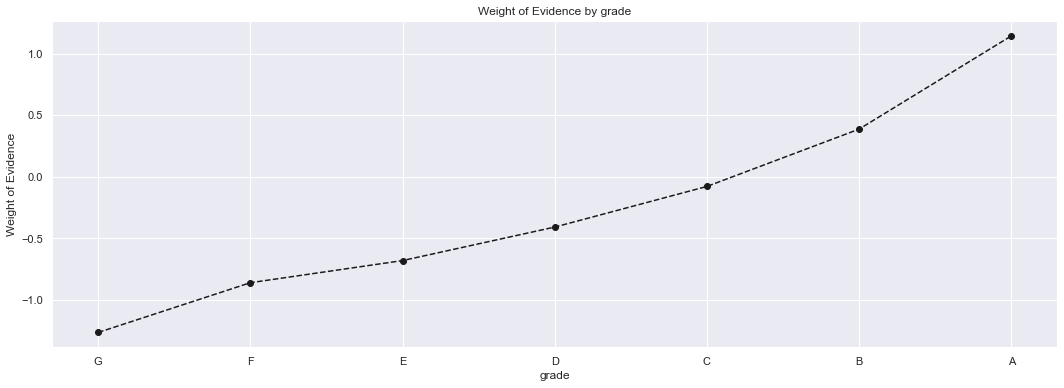

In [396]:
plot_woe(df_temp)

In [397]:
# compute WoE for home_ownership
df_temp = woe_discrete(sample_input_df, 'home_ownership', sample_target_df)
df_temp
# COMMENT: 
# Other and None has the most bad (=worst good) (=lower WoE = most negative WoE) but their number of observation is tiny --> hence can combine with the next most bad category: Rent.
# Any has only 1 observation --> hence can also combine with Other, None and Rent without affecting the WoE.
# Own cannot be combined with Rent because their WoE are quite different and opposite sign. 
# Mortgage cannot be combine with other category because their number of observation is large.

,home_ownership,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,OTHER,45,0.777778,0.000483,35.0,10.0,0.000421,0.000981,-0.845478,NaN,NaN,0.022938
1,NONE,10,0.800000,0.000107,8.0,2.0,0.000096,0.000196,-0.711946,0.022222,0.133531,0.022938
2,RENT,37874,0.874003,0.406125,33102.0,4772.0,0.398498,0.468302,-0.161412,0.074003,0.550534,0.022938
3,OWN,8409,0.888572,0.090170,7472.0,937.0,0.089951,0.091953,-0.022006,0.014568,0.139406,0.022938
4,MORTGAGE,46919,0.904751,0.503115,42450.0,4469.0,0.511033,0.438567,0.152922,0.016179,0.174928,0.022938


In [398]:
sample_input_df['home_ownership:Rent_Other_None_Any'] = sum([
    sample_input_df['home_ownership:RENT'],
    sample_input_df['home_ownership:OTHER'],
    sample_input_df['home_ownership:NONE'],
    sample_input_df['home_ownership:ANY']
])   # combine home_ownership: Other + None + Rent + Any = 1 if belongs to any of the 4 categories, 0 otherwise

In [399]:
sample_input_df['addr_state'].unique()

array(['CA', 'IN', 'AZ', 'MI', 'PA', 'MO', 'CT', 'IL', 'SC', 'VA', 'NY',
       'FL', 'TX', 'NC', 'NM', 'NJ', 'KY', 'DE', 'OK', 'CO', 'OH', 'GA',
       'LA', 'WA', 'AL', 'TN', 'MD', 'NV', 'MN', 'RI', 'NH', 'MA', 'MS',
       'UT', 'WV', 'HI', 'KS', 'OR', 'WY', 'WI', 'AK', 'DC', 'AR', 'MT',
       'SD', 'VT', 'IA', 'ID', 'ME', 'NE'], dtype=object)

In [400]:
# compute WoE for customer's address state
df_temp = woe_discrete(sample_input_df, 'addr_state',sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,NE,1,0.000000,0.000011,0.0,1.0,0.000000,0.000098,-inf,NaN,NaN,inf
1,ID,2,0.500000,0.000021,1.0,1.0,0.000012,0.000098,-2.098241,0.500000,inf,inf
2,NV,1298,0.855932,0.013919,1111.0,187.0,0.013375,0.018351,-0.316333,0.355932,1.781907,inf
3,HI,486,0.860082,0.005211,418.0,68.0,0.005032,0.006673,-0.282267,0.004150,0.034067,inf
4,FL,6426,0.870059,0.068906,5591.0,835.0,0.067307,0.081943,-0.196759,0.009977,0.085508,inf
5,AL,1182,0.873096,0.012675,1032.0,150.0,0.012424,0.014720,-0.169622,0.003037,0.027137,inf
6,NJ,3676,0.875408,0.039418,3218.0,458.0,0.038740,0.044946,-0.148595,0.002312,0.021027,inf
7,LA,1130,0.876106,0.012117,990.0,140.0,0.011918,0.013739,-0.142178,0.000698,0.006416,inf
8,NY,8031,0.879965,0.086117,7067.0,964.0,0.085076,0.094603,-0.106141,0.003859,0.036038,inf
9,RI,403,0.880893,0.004321,355.0,48.0,0.004274,0.004711,-0.097324,0.000928,0.008817,inf


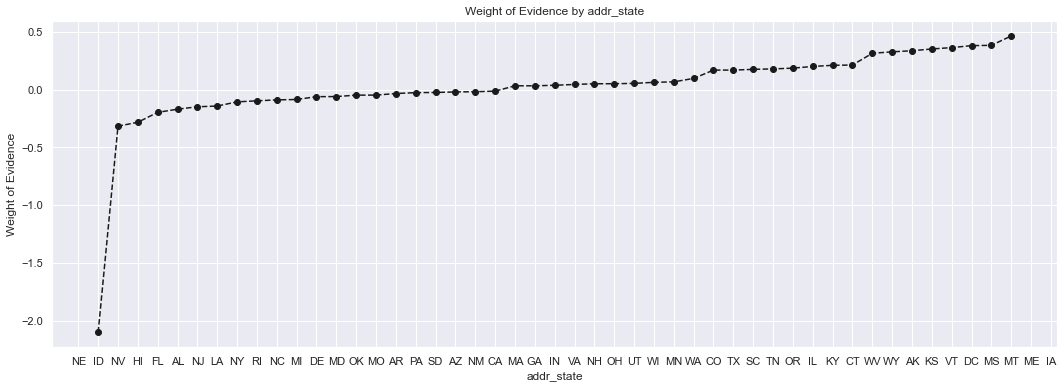

In [401]:
plot_woe(df_temp)
#NOTE:
# NE and IA are much lower than other states
# ME and ID have infinite WoE value because there is no bad observation

In [402]:
# if there is a column name addr_state:ND in the sample input df then we pass. Else create such column with value of 0
if ['addr_state:ND'] in sample_input_df.columns.values:
    pass
else:
    sample_input_df['addr_state:ND'] = 0
# risk manager with the conservative view would put all category with no information to the highest risk category (= worst category)

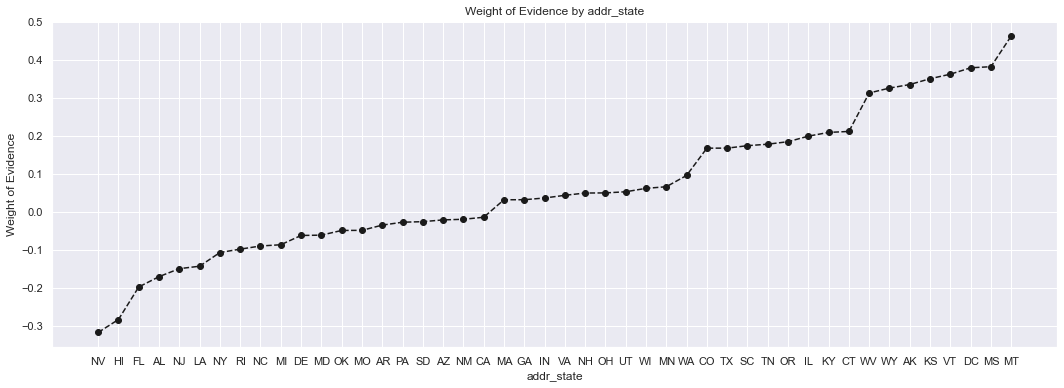

In [403]:
# plot other states apart from the bottom 2 and the first 2 WoE
plot_woe(df_temp.iloc[2:-2, : ])    # from the 3th row to the 3rd lastest row, all columns

# using the below graph and the number of observation in df_temp df to group the categories:
# NV are the lowest in this chart, and relatively low number of obs. FL HI AL have similar WoE. Together with missing ND above, and the worst 2 WoE above NE IA --> grouped together
# top 6 highest WoE can be group together also because of low number of observation: WV NH WY DC ME ID

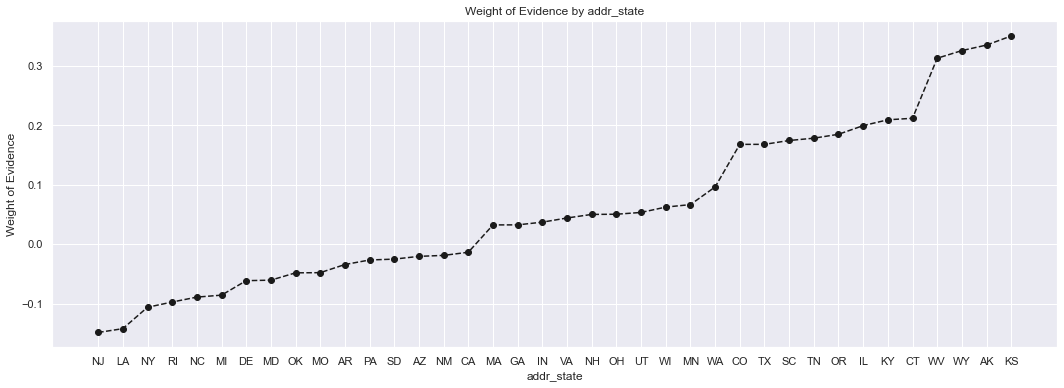

In [404]:
# remaining states apart from those have been categorised above
plot_woe(df_temp.iloc[6:-6, : ]) 

# again, using the below graph and the number of observation in df_temp df to group the categories:
# NM to CA have similar WoE. However, NY and CA have large number of observations --> they are in their own groups. The rest can be grouped together, seperated by NY and CA
# --> NM VA
# NY
# OK TN MO 
# LA 
# MD NC CA
# UT and NJ have similar WoE --> grouped. Since none of them have significant number of observation. 
# likewise for AR MI PA OH MN 
# likewise for RI MA DE SD IN
# likewise for GA WA OR
# WI and MT do not have the similar WoE but low observations --> grouped
# TX have higher observations --> seperate group
# IL CT similar WoE --> grouped 
# KS - MS have high WoE but low observation --> grouped 

In [405]:
# create categories where more than 1 states are combined
sample_input_df['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([
    sample_input_df['addr_state:ND'],   # missing state
    sample_input_df['addr_state:NE'],   # 2 lowest WoE
    sample_input_df['addr_state:IA'],
    sample_input_df['addr_state:NV'],   
    sample_input_df['addr_state:FL'],
    sample_input_df['addr_state:HI'],
    sample_input_df['addr_state:AL']
])
sample_input_df['addr_state:WV_NH_WY_DC_ME_ID'] = sum([
    sample_input_df['addr_state:WV'],
    sample_input_df['addr_state:NH'],
    sample_input_df['addr_state:WY'],
    sample_input_df['addr_state:DC'],
    sample_input_df['addr_state:ME'],
    sample_input_df['addr_state:ID']
])  #top 6 highest WoE, with low number of observations
sample_input_df['addr_state:NM_VA'] = sum([
    sample_input_df['addr_state:NM'], 
    sample_input_df['addr_state:VA']
])
sample_input_df['addr_state:OK_TN_MO_LA_MD_NC'] = sum([
    sample_input_df['addr_state:OK'], 
    sample_input_df['addr_state:TN'],
    sample_input_df['addr_state:MO'], 
    sample_input_df['addr_state:LA'],
    sample_input_df['addr_state:MD'], 
    sample_input_df['addr_state:NC']
])
sample_input_df['addr_state:UT_KY_AZ_NJ'] = sum([
    sample_input_df['addr_state:UT'], 
    sample_input_df['addr_state:KY'],
    sample_input_df['addr_state:AZ'], 
    sample_input_df['addr_state:NJ']
])
sample_input_df['addr_state:AR_MI_PA_OH_MN'] = sum([
    sample_input_df['addr_state:AR'], 
    sample_input_df['addr_state:MI'],
    sample_input_df['addr_state:PA'], 
    sample_input_df['addr_state:OH'],
    sample_input_df['addr_state:MN']
])
sample_input_df['addr_state:RI_MA_DE_SD_IN'] = sum([
    sample_input_df['addr_state:RI'], 
    sample_input_df['addr_state:MA'],
    sample_input_df['addr_state:DE'], 
    sample_input_df['addr_state:SD'],
    sample_input_df['addr_state:IN']
])
sample_input_df['addr_state:GA_WA_OR'] = sum([
    sample_input_df['addr_state:GA'], 
    sample_input_df['addr_state:WA'],
    sample_input_df['addr_state:OR']
])
sample_input_df['addr_state:WI_MT'] = sum([
    sample_input_df['addr_state:WI'], 
    sample_input_df['addr_state:MT']
])
sample_input_df['addr_state:IL_CT'] = sum([
    sample_input_df['addr_state:IL'], 
    sample_input_df['addr_state:CT']
])
sample_input_df['addr_state:KS_SC_CO_VT_AK_MS'] = sum([
    sample_input_df['addr_state:KS'], 
    sample_input_df['addr_state:SC'],
    sample_input_df['addr_state:CO'], 
    sample_input_df['addr_state:VT'],
    sample_input_df['addr_state:AK'], 
    sample_input_df['addr_state:MS']
])

In [406]:
# discrete variable: verification_status
df_temp = woe_discrete(sample_input_df, 'verification_status', sample_target_df)
df_temp

,verification_status,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,Verified,33641,0.872031,0.360734,29336.0,4305.0,0.353161,0.422473,-0.179202,NaN,NaN,0.022684
1,Source Verified,29963,0.895738,0.321295,26839.0,3124.0,0.323101,0.306575,0.052501,0.023707,0.231704,0.022684
2,Not Verified,29653,0.906890,0.317971,26892.0,2761.0,0.323739,0.270952,0.177995,0.011152,0.125494,0.022684


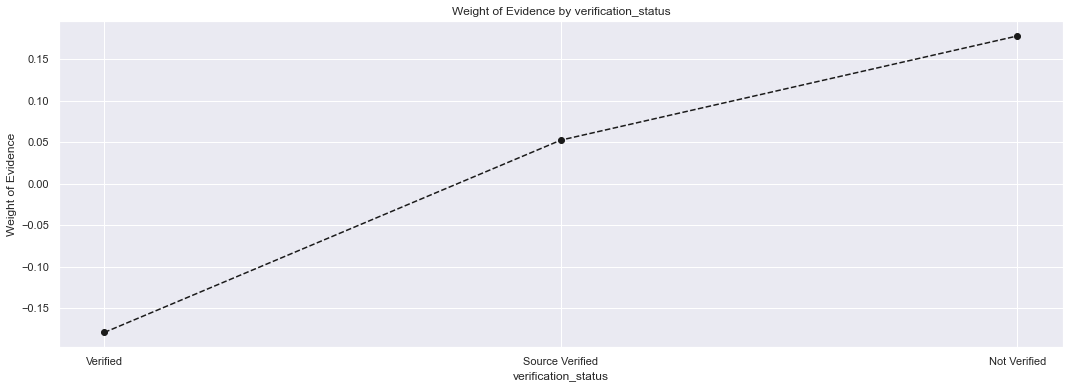

In [407]:
plot_woe(df_temp)

In [408]:
# discrete variable: purpose
df_temp = woe_discrete(sample_input_df, 'purpose', sample_target_df)
df_temp

,purpose,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,educational,89,0.752809,0.000954,67.0,22.0,0.000807,0.002159,-0.984590,NaN,NaN,0.045124
1,renewable_energy,70,0.771429,0.000751,54.0,16.0,0.000650,0.001570,-0.881845,0.018620,0.102745,0.045124
2,small_business,1431,0.777079,0.015345,1112.0,319.0,0.013387,0.031305,-0.849516,0.005650,0.032329,0.045124
3,medical,918,0.857298,0.009844,787.0,131.0,0.009474,0.012856,-0.305210,0.080220,0.544307,0.045124
4,house,439,0.858770,0.004707,377.0,62.0,0.004539,0.006084,-0.293130,0.001471,0.012080,0.045124
5,other,4806,0.861007,0.051535,4138.0,668.0,0.049815,0.065554,-0.274561,0.002237,0.018569,0.045124
6,wedding,456,0.864035,0.004890,394.0,62.0,0.004743,0.006084,-0.249024,0.003028,0.025537,0.045124
7,moving,602,0.878738,0.006455,529.0,73.0,0.006368,0.007164,-0.117712,0.014702,0.131312,0.045124
8,vacation,496,0.881048,0.005319,437.0,59.0,0.005261,0.005790,-0.095845,0.002311,0.021867,0.045124
9,debt_consolidation,55012,0.885916,0.589897,48736.0,6276.0,0.586707,0.615898,-0.048556,0.004867,0.047289,0.045124


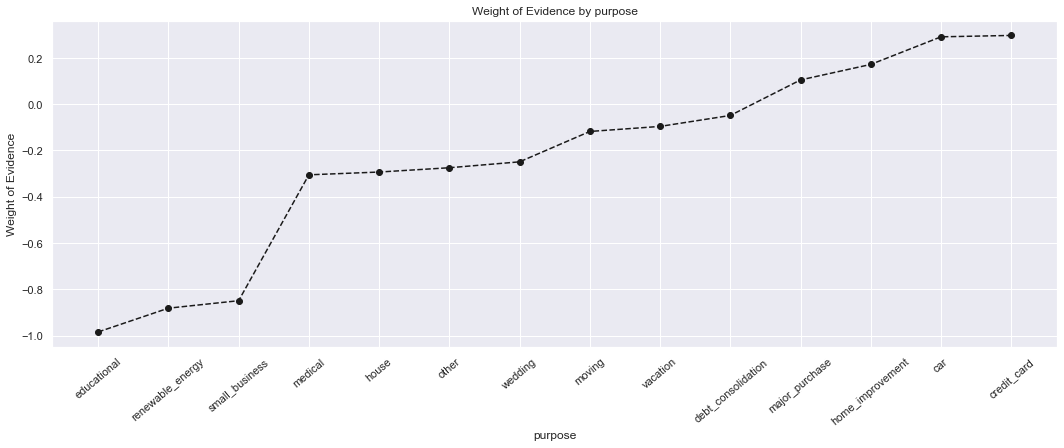

In [409]:
plot_woe(df_temp, 40)

In [410]:
# group couple of categories together 
sample_input_df['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([
    sample_input_df['purpose:educational'], 
    sample_input_df['purpose:small_business'],
    sample_input_df['purpose:wedding'], 
    sample_input_df['purpose:renewable_energy'],
    sample_input_df['purpose:moving'], 
    sample_input_df['purpose:house']
])
sample_input_df['purpose:oth__med__vacation'] = sum([
    sample_input_df['purpose:other'], 
    sample_input_df['purpose:medical'],
    sample_input_df['purpose:vacation']
])
sample_input_df['purpose:debt_consolidation'] = sample_input_df['purpose:debt_consolidation']   # own category
sample_input_df['purpose:major_purch__car__home_impr'] = sum([
    sample_input_df['purpose:major_purchase'], 
    sample_input_df['purpose:car'],
    sample_input_df['purpose:home_improvement']
])
sample_input_df['purpose:credit_card'] = sample_input_df['purpose:credit_card']   # own category

In [411]:
# discrete variable: initial_list_status
df_temp = woe_discrete(sample_input_df, 'initial_list_status', sample_target_df)
df_temp

,initial_list_status,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,f,60491,0.879685,0.648648,53213.0,7278.0,0.640603,0.71423,-0.108794,NaN,NaN,0.024888
1,w,32766,0.911127,0.351352,29854.0,2912.0,0.359397,0.28577,0.229238,0.031443,0.338032,0.024888


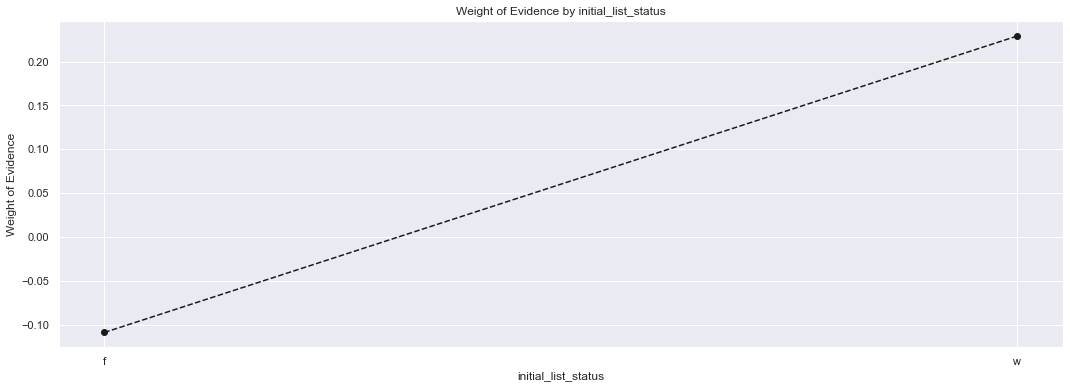

In [412]:
plot_woe(df_temp)

### data preparation: write a function to compute Weight of Evidence, Information Value for any continuous variable

In [413]:
# use similar function as the WoE discrete. But not sort by WoE. Rather sort by original variable values
def woe_continuous(df, continuous_variable_name, good_bad_df):
    df = pd.concat(
        [df[continuous_variable_name], good_bad_df],
        axis=1
    )       #concat independent variable and dependent variable
    df = pd.concat(
        [
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].count(),
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].mean()
        ],
        axis=1 
    )   #compute count of each category in the dependent variable and % of good in each category
    df = df.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
    df.columns = [df.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
    df['prcnt_n_obs'] = df['n_obs']/df['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
    
    df['n_good'] = df['n_obs'] * df['prcnt_good']        #number of good in each category
    df['n_bad'] = df['n_obs'] * (1 - df['prcnt_good'])        #number of bad in each category
    
    df['prcnt_n_good'] = df['n_good']/df['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
    df['prcnt_n_bad'] = df['n_bad']/df['n_bad'].sum()        #likewise for the proportion of number of bad
    
    df['WoE'] = np.log(df['prcnt_n_good']/df['prcnt_n_bad']) #compute Weight of Evidence
    
    #df = df.sort_values(['WoE'])  #sort by WoE
    #df = df.reset_index(drop=True)    #reset index, drop old index
    
    df['diff_prcnt_good'] = df['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
    df['diff_WoE'] = df['WoE'].diff().abs()     #compute row difference in column WoE
    
    df['IV'] = (df['prcnt_n_good'] - df['prcnt_n_bad']) * df['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
    df['IV'] = df['IV'].sum()		#sum all IV value across all categories

    return df

In [414]:
# compute and visualise WoE for continuous variable Term_int
df_temp = woe_continuous(sample_input_df, 'term_int', sample_target_df)
df_temp
# term=60 is riskier than term=36

,term_int,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,36,67534,0.902597,0.724171,60956.0,6578.0,0.733817,0.645535,0.128181,NaN,NaN,0.036603
1,60,25723,0.859581,0.275829,22111.0,3612.0,0.266183,0.354465,-0.286427,0.043016,0.414608,0.036603


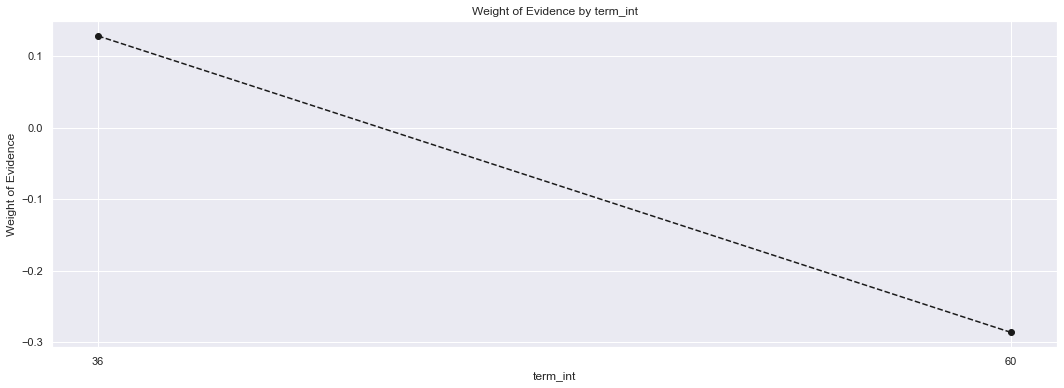

In [415]:
plot_woe(df_temp)

In [416]:
#create dummy variables from continuous variable term_int
sample_input_df['term:36'] = np.where(
    sample_input_df['term_int']==36,
    1,
    0
)   # set value for the dummy variable term:36 = 1 when term_int=36. = 0 otherwise
sample_input_df['term:60'] = np.where(sample_input_df['term_int']==60,1,0)

In [417]:
# compute and visualise WoE for continuous variable emp_length
df_temp = woe_continuous(sample_input_df, 'emp_length_int', sample_target_df)
df_temp

,emp_length_int,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,11553,0.874491,0.123883,10103.0,1450.0,0.121625,0.142296,-0.156972,NaN,NaN,0.007766
1,1.0,5968,0.892594,0.063995,5327.0,641.0,0.064129,0.062905,0.019273,0.018102,0.176245,0.007766
2,2.0,8295,0.887402,0.088948,7361.0,934.0,0.088615,0.091658,-0.033766,0.005192,0.053039,0.007766
3,3.0,7391,0.889325,0.079254,6573.0,818.0,0.079129,0.080275,-0.014377,0.001923,0.019389,0.007766
4,4.0,5555,0.889469,0.059567,4941.0,614.0,0.059482,0.060255,-0.012913,0.000144,0.001465,0.007766
5,5.0,6172,0.886261,0.066183,5470.0,702.0,0.065850,0.068891,-0.045140,0.003208,0.032228,0.007766
6,6.0,5225,0.878852,0.056028,4592.0,633.0,0.055281,0.062120,-0.116640,0.007409,0.071500,0.007766
7,7.0,5131,0.893588,0.055020,4585.0,546.0,0.055196,0.053582,0.029686,0.014736,0.146326,0.007766
8,8.0,4542,0.890137,0.048704,4043.0,499.0,0.048672,0.048970,-0.006104,0.003451,0.035790,0.007766
9,9.0,3621,0.892847,0.038828,3233.0,388.0,0.038920,0.038077,0.021920,0.002711,0.028024,0.007766


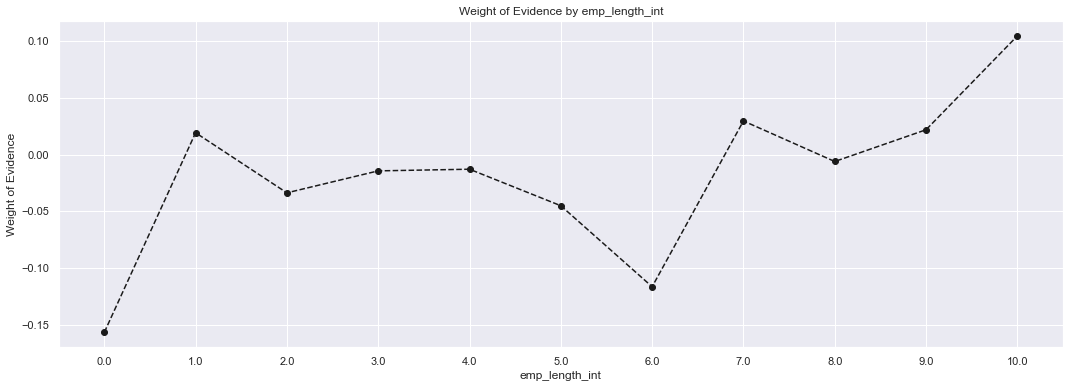

In [418]:
plot_woe(df_temp)

In [419]:
#create dummy variables from continuous variable term_int
sample_input_df['emp_length:0'] = np.where(sample_input_df['emp_length_int'].isin([0]),1,0)
sample_input_df['emp_length:1'] = np.where(sample_input_df['emp_length_int'].isin([1]),1,0)
sample_input_df['emp_length:2-4'] = np.where(sample_input_df['emp_length_int'].isin(range(2,5)),1,0)    #coarse classing. Range value from 2 to 4, exclude 5
sample_input_df['emp_length:5-6'] = np.where(sample_input_df['emp_length_int'].isin(range(5,7)),1,0)
sample_input_df['emp_length:7-9'] = np.where(sample_input_df['emp_length_int'].isin(range(7,10)),1,0)
sample_input_df['emp_length:10'] = np.where(sample_input_df['emp_length_int'].isin([10]),1,0)

In [420]:
# inspect continuous variable mnths_since_issue_d
sample_input_df['mths_since_issue_d']

362514    41.0
288564    38.0
213591    66.0
263083    37.0
165001    58.0
          ... 
115       72.0
296284    38.0
61777     49.0
91763     51.0
167512    58.0
Name: mths_since_issue_d, Length: 93257, dtype: float64

In [421]:
sample_input_df['mths_since_issue_d'].unique()  
# there are 100 unique values --> we would like to trim it down

array([ 41.,  38.,  66.,  37.,  58.,  50.,  86.,  51.,  48.,  59.,  72.,
        77.,  47.,  46.,  56.,  55., 119.,  63., 102.,  39.,  53.,  40.,
        52.,  43.,  49.,  57.,  45.,  36.,  54.,  74.,  44.,  73., 103.,
        70.,  95.,  89.,  68.,  82.,  71.,  76., 104.,  65.,  80.,  91.,
        75.,  67.,  42.,  61.,  64.,  60.,  85.,  88., 110.,  96.,  78.,
        83.,  69.,  90.,  62., 108.,  79.,  92., 118.,  99.,  81., 115.,
        97., 114., 116., 100.,  93., 117., 106., 124., 101., 125.,  87.,
        84.,  94., 105., 109.,  98., 107., 112., 113., 122., 111., 120.,
       121., 123., 126.])

In [422]:
# use panda's cut function to trim the variable down
sample_input_df['mths_since_issue_d_factor'] = pd.cut(sample_input_df['mths_since_issue_d'], 50)     #factor = common used term for categorical variable
sample_input_df['mths_since_issue_d_factor'] 

362514     (39.6, 41.4]
288564     (37.8, 39.6]
213591     (64.8, 66.6]
263083    (35.91, 37.8]
165001     (57.6, 59.4]
              ...      
115        (70.2, 72.0]
296284     (37.8, 39.6]
61777      (48.6, 50.4]
91763      (50.4, 52.2]
167512     (57.6, 59.4]
Name: mths_since_issue_d_factor, Length: 93257, dtype: category
Categories (50, interval[float64]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [423]:
# compute and visualise WoE for continuous variable mths_since_issue_d_factor
df_temp = woe_continuous(sample_input_df, 'mths_since_issue_d_factor', sample_target_df)
df_temp

,mths_since_issue_d_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(35.91, 37.8]",7191,0.945766,0.077109,6801.0,390.0,0.081874,0.038273,0.760438,NaN,NaN,0.126297
1,"(37.8, 39.6]",9752,0.930373,0.104571,9073.0,679.0,0.109225,0.066634,0.494196,0.015392,0.266241,0.126297
2,"(39.6, 41.4]",9506,0.919945,0.101933,8745.0,761.0,0.105276,0.074681,0.343363,0.010428,0.150833,0.126297
3,"(41.4, 43.2]",7240,0.909116,0.077635,6582.0,658.0,0.079237,0.064573,0.204648,0.010829,0.138715,0.126297
4,"(43.2, 45.0]",7217,0.902868,0.077388,6516.0,701.0,0.078443,0.068793,0.131267,0.006248,0.073381,0.126297
5,"(45.0, 46.8]",3104,0.895296,0.033284,2779.0,325.0,0.033455,0.031894,0.047781,0.007572,0.083487,0.126297
6,"(46.8, 48.6]",6197,0.890269,0.066451,5517.0,680.0,0.066416,0.066732,-0.004744,0.005027,0.052525,0.126297
7,"(48.6, 50.4]",5821,0.885930,0.062419,5157.0,664.0,0.062082,0.065162,-0.048413,0.004339,0.043669,0.126297
8,"(50.4, 52.2]",5021,0.878909,0.053840,4413.0,608.0,0.053126,0.059666,-0.116106,0.007022,0.067693,0.126297
9,"(52.2, 54.0]",4497,0.874138,0.048222,3931.0,566.0,0.047323,0.055545,-0.160186,0.004770,0.044080,0.126297


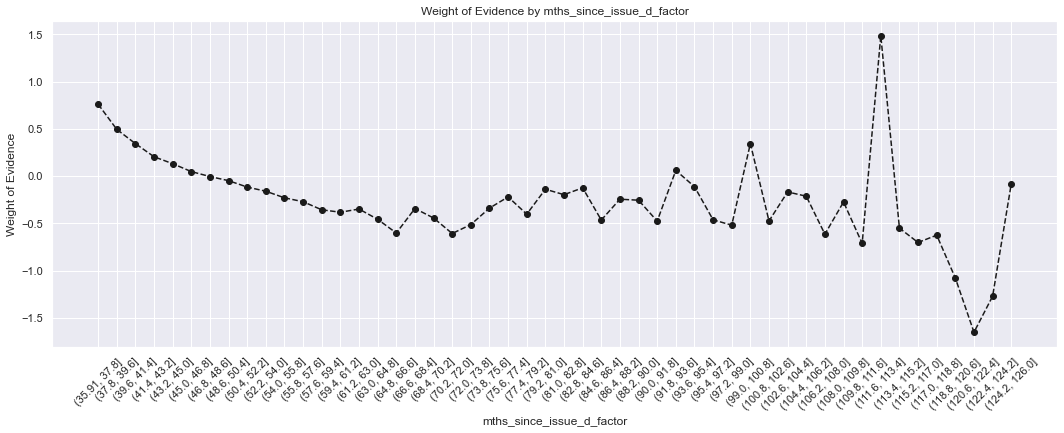

In [424]:
plot_woe(df_temp, 45)

In [425]:
sample_input_df['mths_since_issue_d:<38'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(38)), 1, 0)
sample_input_df['mths_since_issue_d:38-39'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
sample_input_df['mths_since_issue_d:40-41'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
sample_input_df['mths_since_issue_d:42-48'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
sample_input_df['mths_since_issue_d:49-52'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
sample_input_df['mths_since_issue_d:53-64'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
sample_input_df['mths_since_issue_d:65-84'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
sample_input_df['mths_since_issue_d:>84'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(85, int(sample_input_df['mths_since_issue_d'].max()))), 1, 0)

In [426]:
# do the same for continuous variable int_rate. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['int_rate_factor'] = pd.cut(sample_input_df['int_rate'], 50)
df_temp = woe_continuous(sample_input_df, 'int_rate_factor', sample_target_df)
df_temp

,int_rate_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(5.399, 5.833]",198,0.969697,0.002123,192.0,6.0,0.002311,0.000589,1.367495,NaN,NaN,0.371465
1,"(5.833, 6.246]",2086,0.979866,0.022368,2044.0,42.0,0.024607,0.004122,1.786754,0.010169,0.419258,0.371465
2,"(6.246, 6.658]",1974,0.972138,0.021167,1919.0,55.0,0.023102,0.005397,1.453986,0.007728,0.332768,0.371465
3,"(6.658, 7.071]",477,0.951782,0.005115,454.0,23.0,0.005465,0.002257,0.884362,0.020356,0.569623,0.371465
4,"(7.071, 7.484]",804,0.981343,0.008621,789.0,15.0,0.009498,0.001472,1.864475,0.029561,0.980113,0.371465
5,"(7.484, 7.897]",3245,0.965485,0.034796,3133.0,112.0,0.037717,0.010991,1.233007,0.015858,0.631469,0.371465
6,"(7.897, 8.31]",2429,0.951009,0.026046,2310.0,119.0,0.027809,0.011678,0.867639,0.014477,0.365368,0.371465
7,"(8.31, 8.722]",1680,0.965476,0.018015,1622.0,58.0,0.019526,0.005692,1.232732,0.014468,0.365093,0.371465
8,"(8.722, 9.135]",2384,0.942114,0.025564,2246.0,138.0,0.027038,0.013543,0.691412,0.023362,0.541320,0.371465
9,"(9.135, 9.548]",1590,0.976730,0.017050,1553.0,37.0,0.018696,0.003631,1.638785,0.034615,0.947373,0.371465


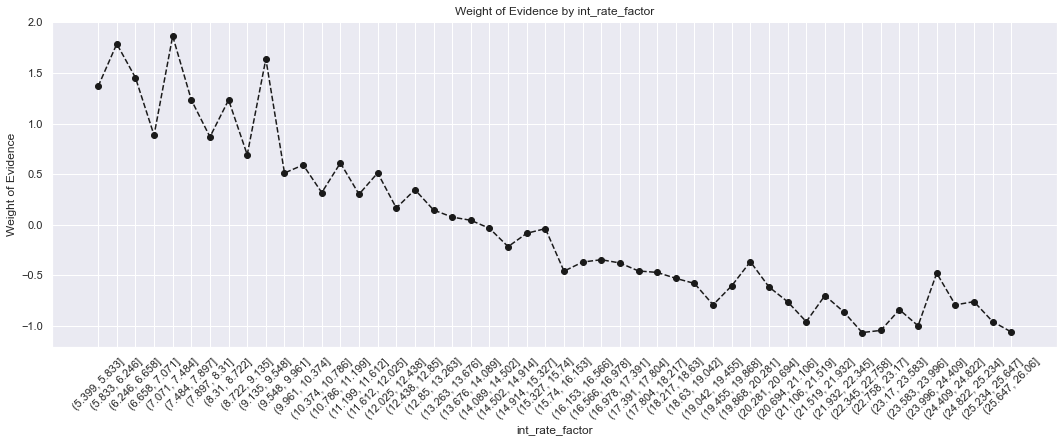

In [427]:
plot_woe(df_temp, 45)

In [428]:
# create coarse classing dummy variables
sample_input_df['int_rate:<9.548'] = np.where((sample_input_df['int_rate'] <= 9.548), 1, 0) #all WoE that are very volatile like those less than 9.548 indicates that they do not have sufficient evidence --> can be grouped together
sample_input_df['int_rate:9.548-12.025'] = np.where((sample_input_df['int_rate'] > 9.548) & (sample_input_df['int_rate'] <= 12.025), 1, 0)
sample_input_df['int_rate:12.025-15.74'] = np.where((sample_input_df['int_rate'] > 12.025) & (sample_input_df['int_rate'] <= 15.74), 1, 0)
sample_input_df['int_rate:15.74-20.281'] = np.where((sample_input_df['int_rate'] > 15.74) & (sample_input_df['int_rate'] <= 20.281), 1, 0)
sample_input_df['int_rate:>20.281'] = np.where((sample_input_df['int_rate'] > 20.281), 1, 0)

In [429]:
# do the same for continuous variable funded_amt. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['funded_amnt_factor'] = pd.cut(sample_input_df['funded_amnt'], 50)
df_temp = woe_continuous(sample_input_df, 'funded_amnt_factor', sample_target_df)
df_temp

,funded_amnt_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(465.5, 1190.0]",319,0.880878,0.003421,281.0,38.0,0.003383,0.003729,-0.097472,NaN,NaN,0.018663
1,"(1190.0, 1880.0]",800,0.896250,0.008578,717.0,83.0,0.008632,0.008145,0.057995,0.015372,0.155467,0.018663
2,"(1880.0, 2570.0]",1513,0.900198,0.016224,1362.0,151.0,0.016396,0.014818,0.101189,0.003948,0.043194,0.018663
3,"(2570.0, 3260.0]",1817,0.893781,0.019484,1624.0,193.0,0.019550,0.018940,0.031717,0.006417,0.069472,0.018663
4,"(3260.0, 3950.0]",1245,0.891566,0.013350,1110.0,135.0,0.013363,0.013248,0.008600,0.002215,0.023117,0.018663
5,"(3950.0, 4640.0]",2298,0.882942,0.024642,2029.0,269.0,0.024426,0.026398,-0.077654,0.008625,0.086254,0.018663
6,"(4640.0, 5330.0]",3957,0.898155,0.042431,3554.0,403.0,0.042785,0.039549,0.078652,0.015213,0.156305,0.018663
7,"(5330.0, 6020.0]",4186,0.906593,0.044887,3795.0,391.0,0.045686,0.038371,0.174491,0.008438,0.095840,0.018663
8,"(6020.0, 6710.0]",1718,0.881839,0.018422,1515.0,203.0,0.018238,0.019921,-0.088276,0.024754,0.262767,0.018663
9,"(6710.0, 7400.0]",2880,0.893403,0.030882,2573.0,307.0,0.030975,0.030128,0.027739,0.011563,0.116015,0.018663


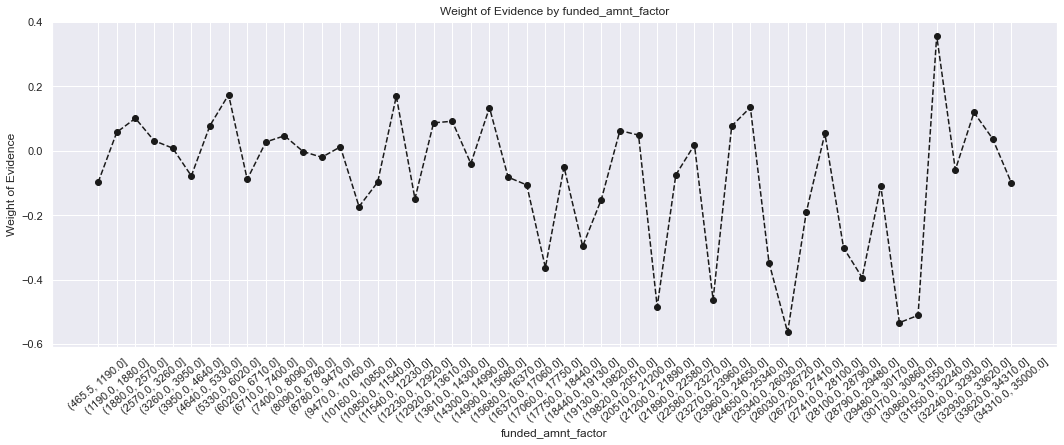

In [430]:
plot_woe(df_temp, 40)
#NOTE: WoE is horizontal for most values --> there seems no evidence of WoE --> not use the variable for the model

In [431]:
# do the same for continuous variable mths_since_earliest_cr_line. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['mths_since_earliest_cr_line'].unique()

array([188., 172., 189., 112., 374., 207., 332., 266., 383., 269., 328.,
       237., 293., 242., 228., 287., 231., 206., 263., 167., 239., 134.,
       441., 195., 127., 286., 192., 518., 170., 147., 150., 252., 202.,
       197., 190., 300., 233., 220., 416., 225., 217., 200., 209., 592.,
       194., 262., 156., 227., 391., 141., 183., 302., 267., 312., 362.,
       216., 438., 249., 273., 182., 221., 187., 567., 245., 205., 347.,
       214., 299., 176., 397., 386., 253., 243., 398., 153., 466., 198.,
       229., 241., 180., 389., 181., 169., 261., 378., 324., 400., 232.,
       486., 123., 350., 549., 139., 244., 255., 126., 219., 175., 115.,
       413., 173., 210., 274., 354., 254., 327., 321., 323., 201., 171.,
       280., 443., 329., 294., 257., 223., 258., 259., 158., 348., 162.,
       168., 303., 313., 298., 320.,  91., 439., 174., 520., 251., 317.,
       144., 204., 246., 406., 119., 304., 279., 379., 230., 160., 305.,
        79., 196., 306., 333., 331., 256., 113., 34

In [432]:
sample_input_df['mths_since_earliest_cr_line_factor'] = pd.cut(sample_input_df['mths_since_earliest_cr_line'], 50)
df_temp = woe_continuous(sample_input_df, 'mths_since_earliest_cr_line_factor', sample_target_df)
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.804, 16.08]",5,1.000000,0.000054,5.0,0.0,0.000060,0.000000,inf,NaN,NaN,inf
1,"(16.08, 32.16]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(32.16, 48.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(48.24, 64.32]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(64.32, 80.4]",122,0.909836,0.001308,111.0,11.0,0.001336,0.001079,0.213394,NaN,NaN,inf
5,"(80.4, 96.48]",713,0.906031,0.007646,646.0,67.0,0.007777,0.006575,0.167866,0.003805,0.045528,inf
6,"(96.48, 112.56]",1234,0.861426,0.013232,1063.0,171.0,0.012797,0.016781,-0.271054,0.044605,0.438920,inf
7,"(112.56, 128.64]",2695,0.866048,0.028899,2334.0,361.0,0.028098,0.035427,-0.231780,0.004622,0.039274,inf
8,"(128.64, 144.72]",4026,0.865127,0.043171,3483.0,543.0,0.041930,0.053288,-0.239701,0.000922,0.007921,inf
9,"(144.72, 160.8]",5087,0.887360,0.054548,4514.0,573.0,0.054342,0.056232,-0.034187,0.022233,0.205513,inf


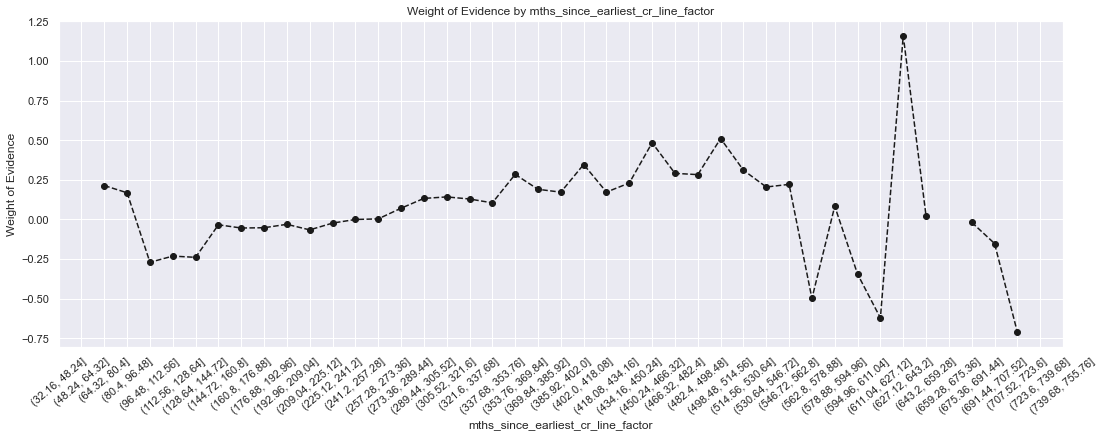

In [433]:
plot_woe(df_temp, 40)

In [434]:
sample_input_df['mths_since_earliest_cr_line:<140'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:141-164'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:165-247'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:248-270'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:271-352'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:>352'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(353, int(sample_input_df['mths_since_earliest_cr_line'].max()))), 1, 0)

In [435]:
# do the same for continuous variable delinq_2yrs. 
sample_input_df['delinq_2yrs'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5.,  7., 16.,  8., 18., 10.,  9.,
       13., 11., 14., 12., 19., 15.])

In [436]:
df_temp = woe_continuous(sample_input_df, 'delinq_2yrs', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,76566,0.890944,0.821021,68216.0,8350.0,0.821217,0.819431,0.002177,NaN,NaN,inf
1,1.0,11297,0.890413,0.121138,10059.0,1238.0,0.121095,0.121492,-0.003270,0.000530,0.005447,inf
2,2.0,3192,0.885025,0.034228,2825.0,367.0,0.034009,0.036016,-0.057339,0.005388,0.054069,inf
3,3.0,1134,0.893298,0.012160,1013.0,121.0,0.012195,0.011874,0.026640,0.008273,0.083979,inf
4,4.0,510,0.886275,0.005469,452.0,58.0,0.005441,0.005692,-0.045001,0.007024,0.071642,inf
5,5.0,270,0.911111,0.002895,246.0,24.0,0.002961,0.002355,0.229037,0.024837,0.274039,inf
6,6.0,128,0.859375,0.001373,110.0,18.0,0.001324,0.001766,-0.288132,0.051736,0.517169,inf
7,7.0,67,0.925373,0.000718,62.0,5.0,0.000746,0.000491,0.419456,0.065998,0.707588,inf
8,8.0,29,0.896552,0.000311,26.0,3.0,0.000313,0.000294,0.061244,0.028821,0.358212,inf
9,9.0,22,0.954545,0.000236,21.0,1.0,0.000253,0.000098,0.946282,0.057994,0.885038,inf


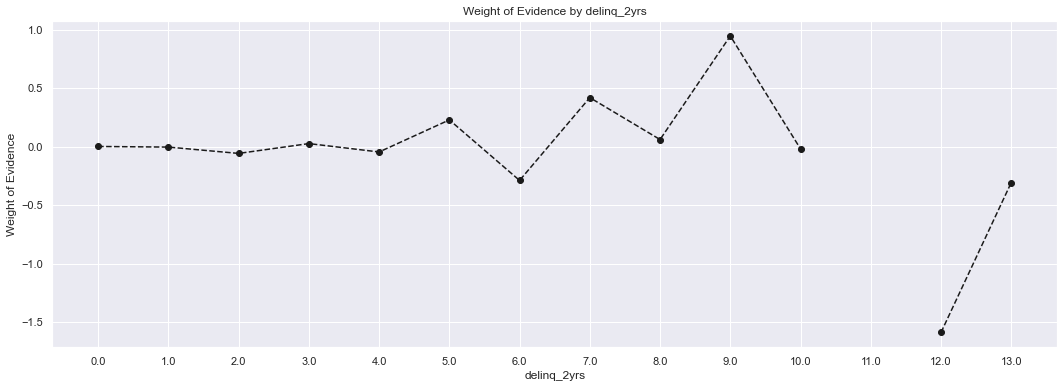

In [437]:
plot_woe(df_temp)

In [438]:
sample_input_df['delinq_2yrs:0'] = np.where((sample_input_df['delinq_2yrs'] == 0), 1, 0)
sample_input_df['delinq_2yrs:1-3'] = np.where((sample_input_df['delinq_2yrs'] >= 1) & (sample_input_df['delinq_2yrs'] <= 3), 1, 0)
sample_input_df['delinq_2yrs:>=4'] = np.where((sample_input_df['delinq_2yrs'] >= 9), 1, 0)

In [439]:
# do the same for continuous variable inq_last_6mths.
df_temp = woe_continuous(sample_input_df, 'inq_last_6mths', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,inq_last_6mths,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,48295,0.910094,0.517870,43953.0,4342.0,0.529127,0.426104,0.216545,NaN,NaN,inf
1,1.0,25985,0.882394,0.278639,22929.0,3056.0,0.276030,0.299902,-0.082945,0.027701,0.299490,inf
2,2.0,11611,0.861252,0.124505,10000.0,1611.0,0.120385,0.158096,-0.272511,0.021141,0.189566,inf
3,3.0,5086,0.846245,0.054537,4304.0,782.0,0.051814,0.076742,-0.392795,0.015008,0.120285,inf
4,4.0,1431,0.841370,0.015345,1204.0,227.0,0.014494,0.022277,-0.429786,0.004875,0.036991,inf
5,5.0,551,0.842105,0.005908,464.0,87.0,0.005586,0.008538,-0.424264,0.000736,0.005522,inf
6,6.0,211,0.763033,0.002263,161.0,50.0,0.001938,0.004907,-0.928859,0.079072,0.504595,inf
7,7.0,36,0.527778,0.000386,19.0,17.0,0.000229,0.001668,-1.987015,0.235255,1.058156,inf
8,8.0,21,0.523810,0.000225,11.0,10.0,0.000132,0.000981,-2.002930,0.003968,0.015915,inf
9,9.0,7,0.428571,0.000075,3.0,4.0,0.000036,0.000393,-2.385923,0.095238,0.382992,inf


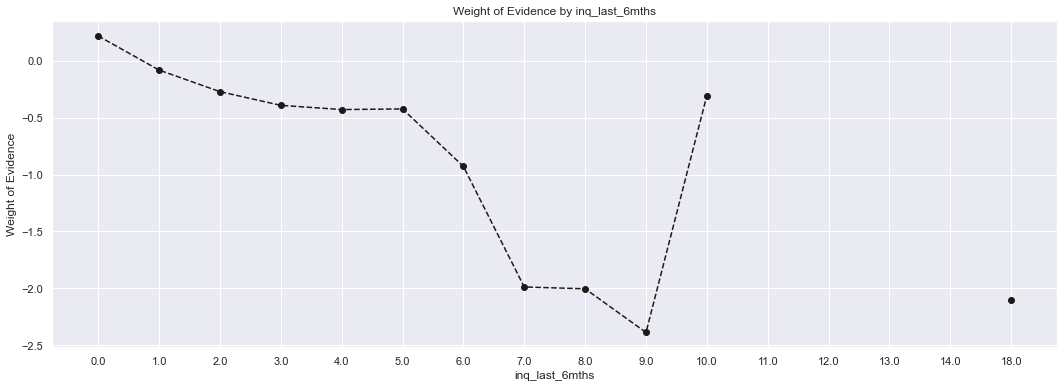

In [440]:
plot_woe(df_temp)

In [441]:
sample_input_df['inq_last_6mths:0'] = np.where((sample_input_df['inq_last_6mths'] == 0), 1, 0)
sample_input_df['inq_last_6mths:1-2'] = np.where((sample_input_df['inq_last_6mths'] >= 1) & (sample_input_df['inq_last_6mths'] <= 2), 1, 0)
sample_input_df['inq_last_6mths:3-6'] = np.where((sample_input_df['inq_last_6mths'] >= 3) & (sample_input_df['inq_last_6mths'] <= 6), 1, 0)
sample_input_df['inq_last_6mths:>6'] = np.where((sample_input_df['inq_last_6mths'] > 6), 1, 0)

In [442]:
# do the same for continuous variable open_acc. 
sample_input_df['open_acc'].unique()

array([ 7., 18.,  9., 12.,  5., 22.,  3., 17., 16.,  6., 10., 20., 23.,
       13.,  4., 15., 14., 11., 19., 24., 21.,  8., 31., 26.,  1., 32.,
       37., 27., 25.,  2., 28., 29., 30., 39., 34., 33., 35., 36., 40.,
        0., 38., 53., 48., 52., 46., 42., 45., 43., 58., 41., 49., 61.,
       50.])

In [443]:
df_temp = woe_continuous(sample_input_df, 'open_acc', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,7,1.000000,0.000075,7.0,0.0,0.000084,0.000000,inf,NaN,NaN,inf
1,1.0,32,0.875000,0.000343,28.0,4.0,0.000337,0.000393,-0.152331,0.125000,inf,inf
2,2.0,334,0.838323,0.003582,280.0,54.0,0.003371,0.005299,-0.452435,0.036677,0.300105,inf
3,3.0,1122,0.852941,0.012031,957.0,165.0,0.011521,0.016192,-0.340383,0.014618,0.112052,inf
4,4.0,2560,0.892188,0.027451,2284.0,276.0,0.027496,0.027085,0.015042,0.039246,0.355425,inf
5,5.0,4403,0.891438,0.047214,3925.0,478.0,0.047251,0.046909,0.007270,0.000750,0.007772,inf
6,6.0,6216,0.890766,0.066655,5537.0,679.0,0.066657,0.066634,0.000346,0.000672,0.006924,inf
7,7.0,7433,0.886856,0.079704,6592.0,841.0,0.079358,0.082532,-0.039220,0.003910,0.039567,inf
8,8.0,8314,0.893433,0.089151,7428.0,886.0,0.089422,0.086948,0.028054,0.006577,0.067275,inf
9,9.0,8768,0.888230,0.094020,7788.0,980.0,0.093756,0.096173,-0.025454,0.005203,0.053508,inf


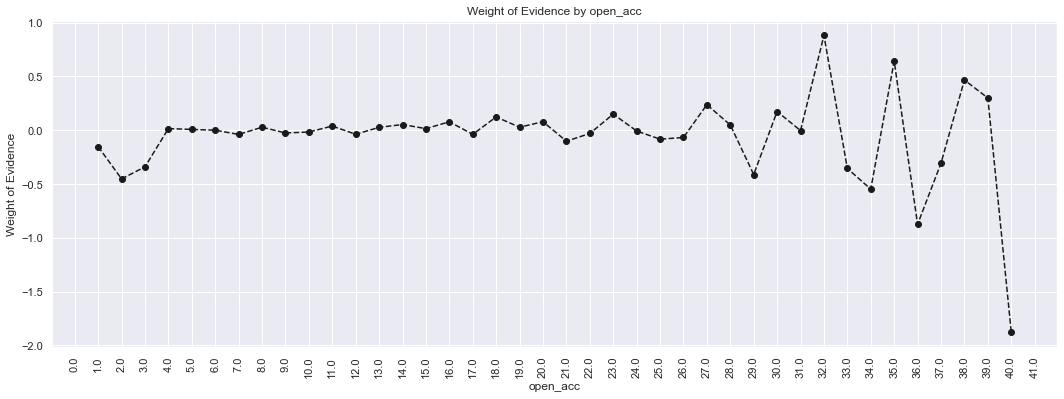

In [444]:
plot_woe(df_temp, 90)

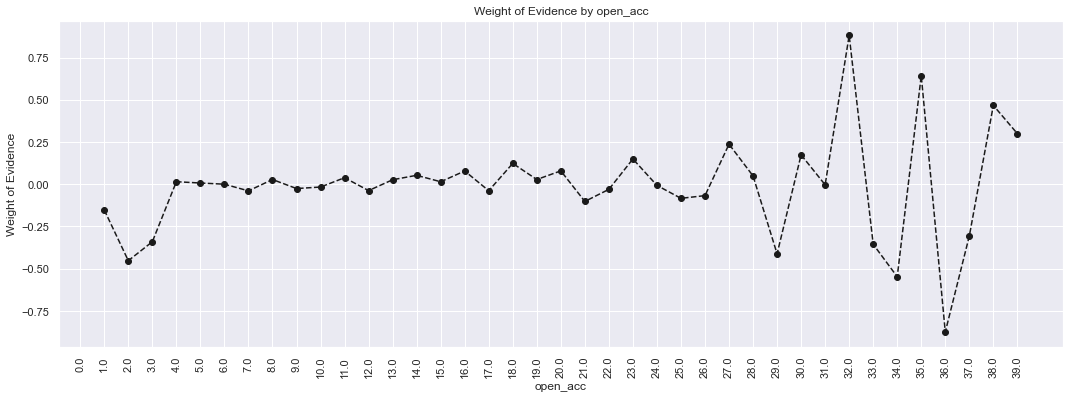

In [445]:
plot_woe(df_temp.iloc[ : 40, :], 90)

In [446]:
sample_input_df['open_acc:0'] = np.where((sample_input_df['open_acc'] == 0), 1, 0)
sample_input_df['open_acc:1-3'] = np.where((sample_input_df['open_acc'] >= 1) & (sample_input_df['open_acc'] <= 3), 1, 0)
sample_input_df['open_acc:4-12'] = np.where((sample_input_df['open_acc'] >= 4) & (sample_input_df['open_acc'] <= 12), 1, 0)
sample_input_df['open_acc:13-17'] = np.where((sample_input_df['open_acc'] >= 13) & (sample_input_df['open_acc'] <= 17), 1, 0)
sample_input_df['open_acc:18-22'] = np.where((sample_input_df['open_acc'] >= 18) & (sample_input_df['open_acc'] <= 22), 1, 0)
sample_input_df['open_acc:23-25'] = np.where((sample_input_df['open_acc'] >= 23) & (sample_input_df['open_acc'] <= 25), 1, 0)
sample_input_df['open_acc:26-30'] = np.where((sample_input_df['open_acc'] >= 26) & (sample_input_df['open_acc'] <= 30), 1, 0)
sample_input_df['open_acc:>=31'] = np.where((sample_input_df['open_acc'] >= 31), 1, 0)

In [447]:
# do the same for continuous variable pub_rec. 
sample_input_df['pub_rec'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5., 12., 49.,  7.,  6.,  8., 14., 11.,
       10.,  9.])

In [448]:
df_temp = woe_continuous(sample_input_df, 'pub_rec', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,pub_rec,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,80923,0.889179,0.867742,71955.0,8968.0,0.866228,0.880079,-0.015862,NaN,NaN,inf
1,1.0,10670,0.901125,0.114415,9615.0,1055.0,0.115750,0.103533,0.111543,0.011946,0.127405,inf
2,2.0,1097,0.904284,0.011763,992.0,105.0,0.011942,0.010304,0.147522,0.003160,0.035979,inf
3,3.0,331,0.900302,0.003549,298.0,33.0,0.003587,0.003238,0.102345,0.003982,0.045177,inf
4,4.0,112,0.857143,0.001201,96.0,16.0,0.001156,0.001570,-0.306481,0.043159,0.408826,inf
5,5.0,73,0.904110,0.000783,66.0,7.0,0.000795,0.000687,0.145504,0.046967,0.451985,inf
6,6.0,19,0.894737,0.000204,17.0,2.0,0.000205,0.000196,0.041825,0.009373,0.103678,inf
7,7.0,14,0.785714,0.000150,11.0,3.0,0.000132,0.000294,-0.798958,0.109023,0.840783,inf
8,8.0,5,0.800000,0.000054,4.0,1.0,0.000048,0.000098,-0.711946,0.014286,0.087011,inf
9,9.0,2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.200000,inf,inf


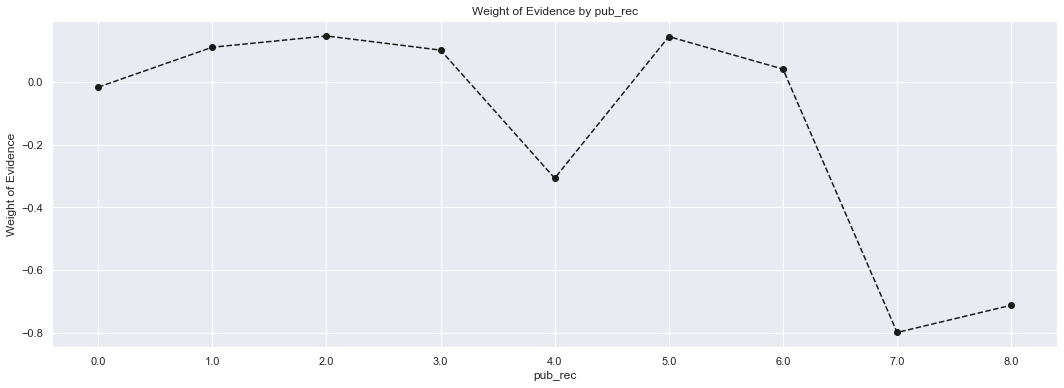

In [449]:
plot_woe(df_temp)

In [450]:
sample_input_df['pub_rec:0-2'] = np.where((sample_input_df['pub_rec'] >= 0) & (sample_input_df['pub_rec'] <= 2), 1, 0)
sample_input_df['pub_rec:3-4'] = np.where((sample_input_df['pub_rec'] >= 3) & (sample_input_df['pub_rec'] <= 4), 1, 0)
sample_input_df['pub_rec:>=5'] = np.where((sample_input_df['pub_rec'] >= 5), 1, 0)

In [451]:
# do the same for continuous variable delinq_2yrs. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['total_acc'].unique()

array([ 20.,  43.,  38.,  31.,  36.,  48.,  10.,  45.,   5.,  32.,  26.,
        41.,  40.,  47.,   8.,  14.,  42.,  24.,   6.,  23.,  17.,  11.,
        25.,  21.,  28.,  29.,  12.,  37.,  19.,  35.,  34.,  30.,  18.,
        13.,   9.,  44.,  50.,  22.,  33.,  59.,  16.,  15.,  27.,  39.,
        46.,  63.,   7.,  52.,  56.,  54.,  49.,   4.,  57.,  60.,  53.,
        67.,  51.,  55.,  65.,  61., 156.,   3.,  66.,  58.,  80.,  64.,
        62.,  73.,  71.,  72.,  91.,  79.,  69.,   2.,  78.,   0.,  81.,
        92.,  74.,  70.,  77.,  75.,  68.,  76.,  85.,  88.,  94.,  97.,
         1.,  99.,  86.,  89.,  84.,  83.,  82.,  93.])

In [452]:
sample_input_df['total_acc_factor'] = pd.cut(sample_input_df['total_acc'], 50)
df_temp = woe_continuous(sample_input_df, 'total_acc_factor', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_acc_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.156, 3.12]",125,0.776000,0.001340,97.0,28.0,0.001168,0.002748,-0.855734,NaN,NaN,inf
1,"(3.12, 6.24]",1499,0.850567,0.016074,1275.0,224.0,0.015349,0.021982,-0.359185,0.074567,0.496549,inf
2,"(6.24, 9.36]",3715,0.871871,0.039836,3239.0,476.0,0.038993,0.046712,-0.180639,0.021304,0.178547,inf
3,"(9.36, 12.48]",6288,0.874841,0.067427,5501.0,787.0,0.066224,0.077233,-0.153784,0.002970,0.026855,inf
4,"(12.48, 15.6]",8289,0.888286,0.088883,7363.0,926.0,0.088639,0.090873,-0.024892,0.013445,0.128892,inf
5,"(15.6, 18.72]",9843,0.890176,0.105547,8762.0,1081.0,0.105481,0.106084,-0.005703,0.001890,0.019189,inf
6,"(18.72, 21.84]",10270,0.893866,0.110126,9180.0,1090.0,0.110513,0.106968,0.032609,0.003690,0.038312,inf
7,"(21.84, 24.96]",9971,0.892789,0.106920,8902.0,1069.0,0.107167,0.104907,0.021312,0.001077,0.011297,inf
8,"(24.96, 28.08]",11873,0.892108,0.127315,10592.0,1281.0,0.127512,0.125711,0.014217,0.000681,0.007094,inf
9,"(28.08, 31.2]",7289,0.892715,0.078160,6507.0,782.0,0.078334,0.076742,0.020538,0.000607,0.006321,inf


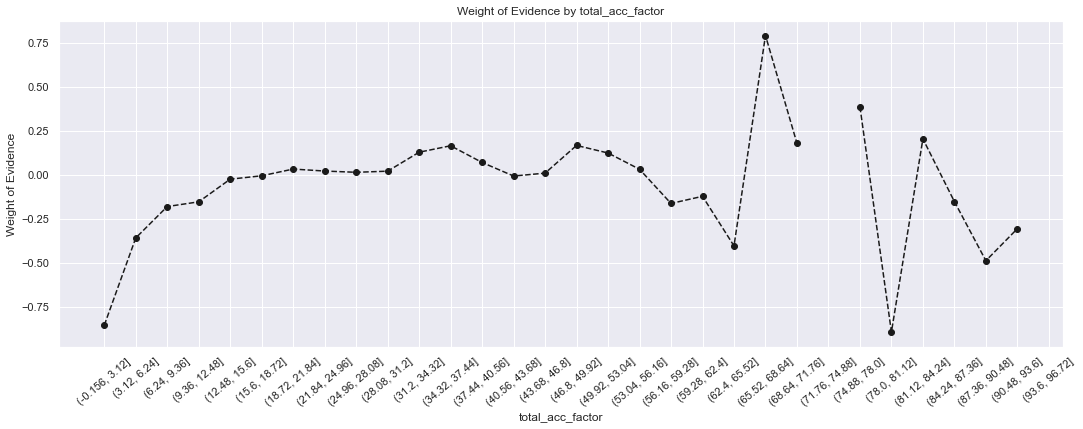

In [453]:
plot_woe(df_temp, 40)

In [454]:
sample_input_df['total_acc:<=27'] = np.where((sample_input_df['total_acc'] <= 27), 1, 0)
sample_input_df['total_acc:28-51'] = np.where((sample_input_df['total_acc'] >= 28) & (sample_input_df['total_acc'] <= 51), 1, 0)
sample_input_df['total_acc:>=52'] = np.where((sample_input_df['total_acc'] >= 52), 1, 0)

In [455]:
# do the same for continuous variable acc_now_delinq. 
sample_input_df['acc_now_delinq'].unique()

array([0., 1., 2., 3.])

In [456]:
df_temp = woe_continuous(sample_input_df, 'acc_now_delinq', sample_target_df)
df_temp

,acc_now_delinq,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,92871,0.890827,0.995861,82732.0,10139.0,0.995967,0.994995,0.000976,NaN,NaN,0.000298
1,1.0,360,0.872222,0.003860,314.0,46.0,0.003780,0.004514,-0.177489,0.018605,0.178466,0.000298
2,2.0,22,0.818182,0.000236,18.0,4.0,0.000217,0.000393,-0.594163,0.054040,0.416674,0.000298
3,3.0,4,0.750000,0.000043,3.0,1.0,0.000036,0.000098,-0.999628,0.068182,0.405465,0.000298


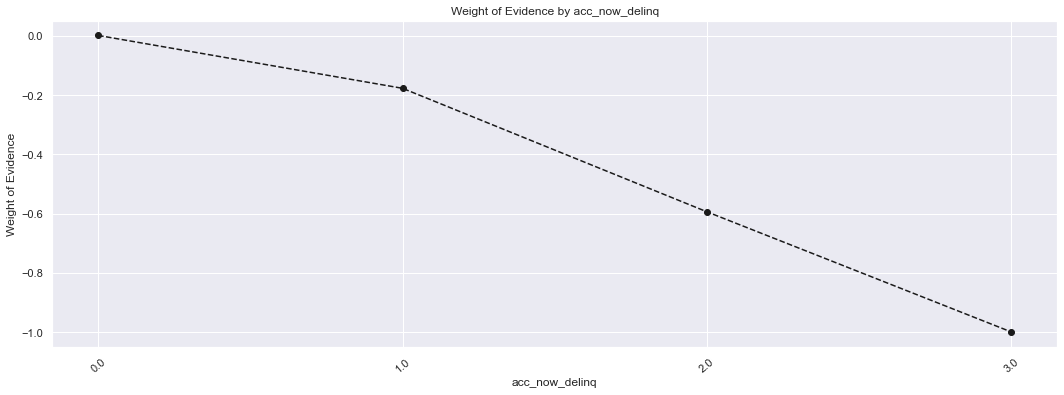

In [457]:
plot_woe(df_temp, 40)

In [458]:
sample_input_df['acc_now_delinq:0'] = np.where((sample_input_df['acc_now_delinq'] == 0), 1, 0)
sample_input_df['acc_now_delinq:>=1'] = np.where((sample_input_df['acc_now_delinq'] >= 1), 1, 0)

In [459]:
# do the same for continuous variable total_rev_hi_lim. Cut by 2000 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['total_rev_hi_lim'].unique()

array([25100., 24000., 30000., ..., 61299., 21188., 13962.])

In [460]:
sample_input_df['total_rev_hi_lim_factor'] = pd.cut(sample_input_df['total_rev_hi_lim'], 2000)
df_temp = woe_continuous(sample_input_df, 'total_rev_hi_lim_factor', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_rev_hi_lim_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-2013.133, 1006.566]",238,0.840336,0.002552,200.0,38.0,0.002408,0.003729,-0.437509,NaN,NaN,inf
1,"(1006.566, 2013.133]",678,0.827434,0.007270,561.0,117.0,0.006754,0.011482,-0.530694,0.012903,0.093184,inf
2,"(2013.133, 3019.7]",1121,0.852810,0.012021,956.0,165.0,0.011509,0.016192,-0.341428,0.025376,0.189265,inf
3,"(3019.7, 4026.266]",1461,0.878166,0.015666,1283.0,178.0,0.015445,0.017468,-0.123068,0.025356,0.218360,inf
4,"(4026.266, 5032.832]",2163,0.867776,0.023194,1877.0,286.0,0.022596,0.028067,-0.216802,0.010389,0.093735,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(2008100.168, 2009106.734]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(2009106.734, 2010113.301]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(2010113.301, 2011119.867]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(2011119.867, 2012126.434]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


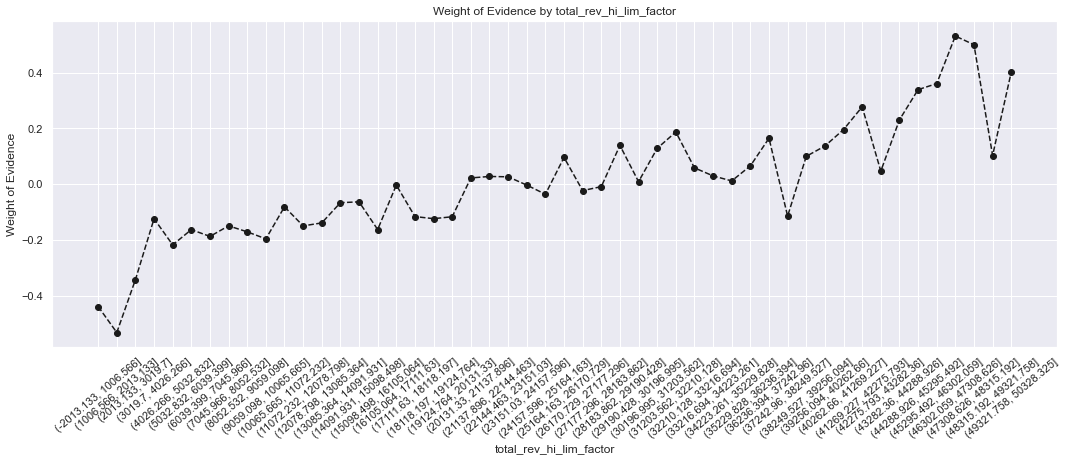

In [461]:
plot_woe(df_temp.iloc[: 50, :], 40)

In [462]:
sample_input_df['total_rev_hi_lim:<=5K'] = np.where((sample_input_df['total_rev_hi_lim'] <= 5000), 1, 0)
sample_input_df['total_rev_hi_lim:5K-10K'] = np.where((sample_input_df['total_rev_hi_lim'] > 5000) & (sample_input_df['total_rev_hi_lim'] <= 10000), 1, 0)
sample_input_df['total_rev_hi_lim:10K-20K'] = np.where((sample_input_df['total_rev_hi_lim'] > 10000) & (sample_input_df['total_rev_hi_lim'] <= 20000), 1, 0)
sample_input_df['total_rev_hi_lim:20K-30K'] = np.where((sample_input_df['total_rev_hi_lim'] > 20000) & (sample_input_df['total_rev_hi_lim'] <= 30000), 1, 0)
sample_input_df['total_rev_hi_lim:30K-40K'] = np.where((sample_input_df['total_rev_hi_lim'] > 30000) & (sample_input_df['total_rev_hi_lim'] <= 40000), 1, 0)
sample_input_df['total_rev_hi_lim:40K-55K'] = np.where((sample_input_df['total_rev_hi_lim'] > 40000) & (sample_input_df['total_rev_hi_lim'] <= 55000), 1, 0)
sample_input_df['total_rev_hi_lim:55K-95K'] = np.where((sample_input_df['total_rev_hi_lim'] > 55000) & (sample_input_df['total_rev_hi_lim'] <= 95000), 1, 0)
sample_input_df['total_rev_hi_lim:>95K'] = np.where((sample_input_df['total_rev_hi_lim'] > 95000), 1, 0)

In [463]:
# do the same for continuous variable installment. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['installment'].unique()

array([ 773.01,  297.53, 1034.83, ...,  414.23,  494.33,  121.42])

In [464]:
sample_input_df['installment_factor'] = pd.cut(sample_input_df['installment'], 50)
df_temp = woe_continuous(sample_input_df, 'installment_factor', sample_target_df)
df_temp

,installment_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(14.369, 43.585]",485,0.872165,0.005201,423.0,62.0,0.005092,0.006084,-0.178003,NaN,NaN,inf
1,"(43.585, 71.41]",1246,0.904494,0.013361,1127.0,119.0,0.013567,0.011678,0.149950,0.032329,0.327953,inf
2,"(71.41, 99.235]",1731,0.895436,0.018562,1550.0,181.0,0.018660,0.017763,0.049273,0.009058,0.100678,inf
3,"(99.235, 127.06]",2292,0.896597,0.024577,2055.0,237.0,0.024739,0.023258,0.061730,0.001161,0.012458,inf
4,"(127.06, 154.885]",2602,0.886241,0.027901,2306.0,296.0,0.027761,0.029048,-0.045330,0.010356,0.107061,inf
5,"(154.885, 182.71]",4133,0.897653,0.044318,3710.0,423.0,0.044663,0.041511,0.073174,0.011412,0.118505,inf
6,"(182.71, 210.535]",4109,0.905086,0.044061,3719.0,390.0,0.044771,0.038273,0.156823,0.007433,0.083648,inf
7,"(210.535, 238.36]",3730,0.901877,0.039997,3364.0,366.0,0.040497,0.035918,0.120012,0.003210,0.036811,inf
8,"(238.36, 266.185]",4660,0.899785,0.049969,4193.0,467.0,0.050477,0.045829,0.096602,0.002091,0.023410,inf
9,"(266.185, 294.01]",4975,0.888844,0.053347,4422.0,553.0,0.053234,0.054269,-0.019251,0.010941,0.115853,inf


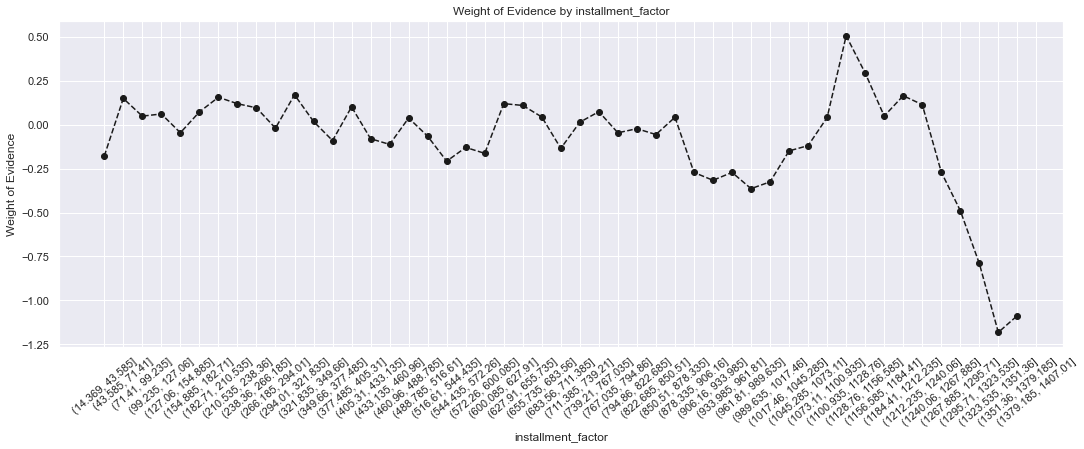

In [465]:
plot_woe(df_temp, 40)

In [466]:
#annual income
# if we fine classing into 50 equal categories, 94% of the observations fall into the first class. Because the range of values of annual income span widely, can be over 1m
# --> can split into high income and low income people --> assuming the threshold of high income vs low income is 140,000
sample_input_df_lowincome = sample_input_df.loc[sample_input_df['annual_inc'] <= 140000, :]     # loc different than iloc in a way that: loc allows to specify condition of the column values that meets the criteria
sample_input_df_lowincome['annual_inc_factor'] = pd.cut(sample_input_df_lowincome['annual_inc'], 50)    # split the new dataframe into 50 equal slices


<ipython-input-466-9a30411ec8b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_lowincome['annual_inc_factor'] = pd.cut(sample_input_df_lowincome['annual_inc'], 50)    # split the new dataframe into 50 equal slices


In [467]:
df_temp = woe_continuous(sample_input_df_lowincome, 'annual_inc_factor', sample_target_df[sample_input_df_lowincome.index])
df_temp

,annual_inc_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(4664.8, 7504.0]",10,1.000000,0.000114,10.0,0.0,0.000128,0.000000,inf,NaN,NaN,inf
1,"(7504.0, 10208.0]",84,0.761905,0.000958,64.0,20.0,0.000822,0.002043,-0.911157,0.238095,inf,inf
2,"(10208.0, 12912.0]",123,0.780488,0.001403,96.0,27.0,0.001232,0.002758,-0.805796,0.018583,0.105361,inf
3,"(12912.0, 15616.0]",304,0.851974,0.003467,259.0,45.0,0.003325,0.004597,-0.324142,0.071486,0.481654,inf
4,"(15616.0, 18320.0]",383,0.827676,0.004368,317.0,66.0,0.004069,0.006743,-0.505060,0.024297,0.180919,inf
5,"(18320.0, 21024.0]",733,0.840382,0.008359,616.0,117.0,0.007907,0.011953,-0.413234,0.012706,0.091826,inf
6,"(21024.0, 23728.0]",704,0.846591,0.008028,596.0,108.0,0.007651,0.011034,-0.366198,0.006209,0.047036,inf
7,"(23728.0, 26432.0]",1785,0.861064,0.020356,1537.0,248.0,0.019730,0.025337,-0.250148,0.014474,0.116050,inf
8,"(26432.0, 29136.0]",1355,0.853137,0.015452,1156.0,199.0,0.014839,0.020331,-0.314891,0.007928,0.064743,inf
9,"(29136.0, 31840.0]",2292,0.854276,0.026137,1958.0,334.0,0.025134,0.034123,-0.305769,0.001139,0.009122,inf


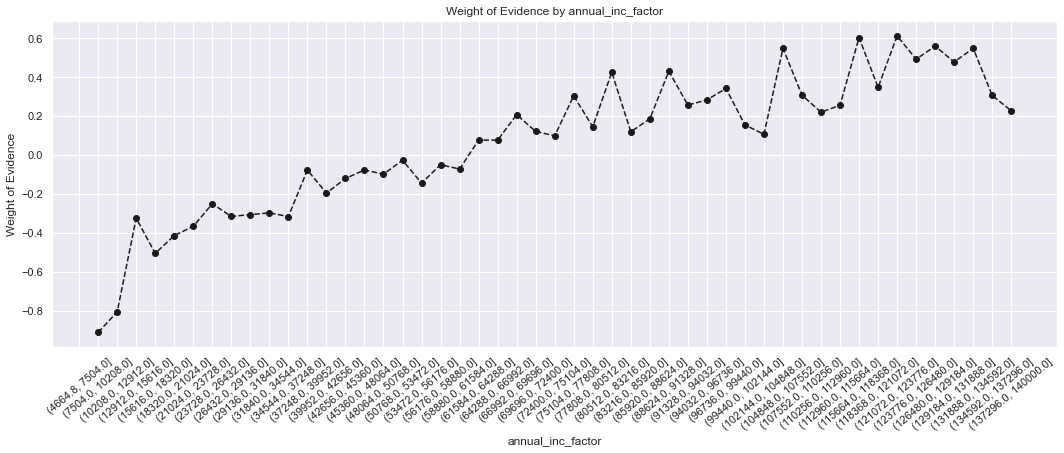

In [468]:
plot_woe(df_temp, 40)

In [469]:
#finally, split the annual income into smaller chunk, especially for the low income. And one big chunk for the high income.
sample_input_df['annual_inc:<20k'] = np.where(sample_input_df['annual_inc'] <= 20000, 1, 0)
sample_input_df['annual_inc:20k-30k'] = np.where((sample_input_df['annual_inc'] > 20000) & (sample_input_df['annual_inc'] <= 30000), 1, 0)
sample_input_df['annual_inc:30k-40k'] = np.where((sample_input_df['annual_inc'] > 30000) & (sample_input_df['annual_inc'] <= 40000), 1, 0)
sample_input_df['annual_inc:40k-50k'] = np.where((sample_input_df['annual_inc'] > 40000) & (sample_input_df['annual_inc'] <= 50000), 1, 0)
sample_input_df['annual_inc:50k-60k'] = np.where((sample_input_df['annual_inc'] > 50000) & (sample_input_df['annual_inc'] <= 60000), 1, 0)
sample_input_df['annual_inc:60k-70k'] = np.where((sample_input_df['annual_inc'] > 60000) & (sample_input_df['annual_inc'] <= 70000), 1, 0)
sample_input_df['annual_inc:70k-80k'] = np.where((sample_input_df['annual_inc'] > 70000) & (sample_input_df['annual_inc'] <= 80000), 1, 0)
sample_input_df['annual_inc:80k-90k'] = np.where((sample_input_df['annual_inc'] > 80000) & (sample_input_df['annual_inc'] <= 90000), 1, 0)
sample_input_df['annual_inc:90k-100k'] = np.where((sample_input_df['annual_inc'] > 90000) & (sample_input_df['annual_inc'] <= 100000), 1, 0)
sample_input_df['annual_inc:100k-120k'] = np.where((sample_input_df['annual_inc'] > 100000) & (sample_input_df['annual_inc'] <= 120000), 1, 0)
sample_input_df['annual_inc:120k-140k'] = np.where((sample_input_df['annual_inc'] > 120000) & (sample_input_df['annual_inc'] <= 140000), 1, 0)
sample_input_df['annual_inc:>140k'] = np.where(sample_input_df['annual_inc'] > 140000, 1, 0)

In [470]:
#mths_since_last_delinq
sample_input_df_everDelq = sample_input_df[pd.notnull(sample_input_df['mths_since_last_delinq'])]       #create new subset df where last delq is not null --> i.e. have been delq in the past
sample_input_df_everDelq['mths_since_last_delinq_factor'] = pd.cut(sample_input_df_everDelq['mths_since_last_delinq'], 50)
df_temp = woe_continuous(sample_input_df_everDelq, 'mths_since_last_delinq_factor', sample_target_df[sample_input_df_everDelq.index])
df_temp

<ipython-input-470-92cee158fc88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_everDelq['mths_since_last_delinq_factor'] = pd.cut(sample_input_df_everDelq['mths_since_last_delinq'], 50)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.17, 3.4]",1348,0.868694,0.031283,1171.0,177.0,0.030501,0.037668,-0.211036,NaN,NaN,inf
1,"(3.4, 6.8]",1890,0.880423,0.043861,1664.0,226.0,0.043342,0.048095,-0.104055,0.011729,0.106981,inf
2,"(6.8, 10.2]",3373,0.887044,0.078276,2992.0,381.0,0.077933,0.081081,-0.039601,0.006621,0.064453,inf
3,"(10.2, 13.6]",2496,0.895833,0.057924,2236.0,260.0,0.058241,0.055331,0.051263,0.008789,0.090864,inf
4,"(13.6, 17.0]",3165,0.884044,0.073449,2798.0,367.0,0.072880,0.078102,-0.069201,0.011789,0.120464,inf
5,"(17.0, 20.4]",2282,0.893076,0.052958,2038.0,244.0,0.053084,0.051926,0.022057,0.009032,0.091258,inf
6,"(20.4, 23.8]",2115,0.898345,0.049082,1900.0,215.0,0.049489,0.045754,0.078472,0.005269,0.056415,inf
7,"(23.8, 27.2]",2755,0.895463,0.063934,2467.0,288.0,0.064258,0.061290,0.047298,0.002882,0.031174,inf
8,"(27.2, 30.6]",1929,0.896319,0.044766,1729.0,200.0,0.045035,0.042562,0.056482,0.000857,0.009183,inf
9,"(30.6, 34.0]",2453,0.891969,0.056926,2188.0,265.0,0.056991,0.056395,0.010514,0.004350,0.045968,inf


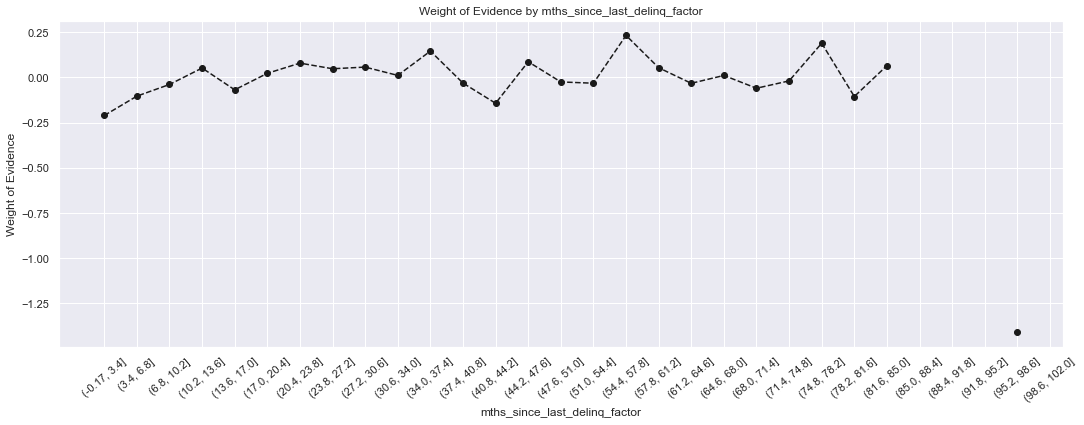

In [471]:
plot_woe(df_temp, 40)

In [472]:
sample_input_df['mths_since_last_delinq:Missing'] = np.where((sample_input_df['mths_since_last_delinq'].isnull()), 1, 0)
sample_input_df['mths_since_last_delinq:0-3'] = np.where((sample_input_df['mths_since_last_delinq'] >=0) & (sample_input_df['mths_since_last_delinq'] <= 3), 1, 0)
sample_input_df['mths_since_last_delinq:4-30'] = np.where((sample_input_df['mths_since_last_delinq'] >= 4) & (sample_input_df['mths_since_last_delinq'] <= 30), 1, 0)
sample_input_df['mths_since_last_delinq:31-56'] = np.where((sample_input_df['mths_since_last_delinq'] >= 31) & (sample_input_df['mths_since_last_delinq'] <= 56), 1, 0)
sample_input_df['mths_since_last_delinq:>56'] = np.where(sample_input_df['mths_since_last_delinq'] > 56, 1, 0)

In [473]:
#dti
sample_input_df['dti_factor'] = pd.cut(sample_input_df['dti'], 50)
df_temp = woe_continuous(sample_input_df, 'dti_factor', sample_target_df)
df_temp

,dti_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.04, 0.8]",371,0.886792,0.003978,329.0,42.0,0.003961,0.004122,-0.039853,NaN,NaN,0.032501
1,"(0.8, 1.6]",478,0.899582,0.005126,430.0,48.0,0.005177,0.004711,0.094344,0.012789,0.134196,0.032501
2,"(1.6, 2.399]",639,0.902973,0.006852,577.0,62.0,0.006946,0.006084,0.132467,0.003392,0.038124,0.032501
3,"(2.399, 3.199]",808,0.912129,0.008664,737.0,71.0,0.008872,0.006968,0.241667,0.009155,0.109200,0.032501
4,"(3.199, 3.999]",1047,0.916905,0.011227,960.0,87.0,0.011557,0.008538,0.302785,0.004777,0.061117,0.032501
5,"(3.999, 4.799]",1260,0.912698,0.013511,1150.0,110.0,0.013844,0.010795,0.248796,0.004207,0.053988,0.032501
6,"(4.799, 5.599]",1527,0.912901,0.016374,1394.0,133.0,0.016782,0.013052,0.251343,0.000203,0.002547,0.032501
7,"(5.599, 6.398]",1730,0.905202,0.018551,1566.0,164.0,0.018852,0.016094,0.158173,0.007699,0.093170,0.032501
8,"(6.398, 7.198]",1999,0.919960,0.021435,1839.0,160.0,0.022139,0.015702,0.343563,0.014758,0.185390,0.032501
9,"(7.198, 7.998]",2227,0.908846,0.023880,2024.0,203.0,0.024366,0.019921,0.201384,0.011114,0.142178,0.032501


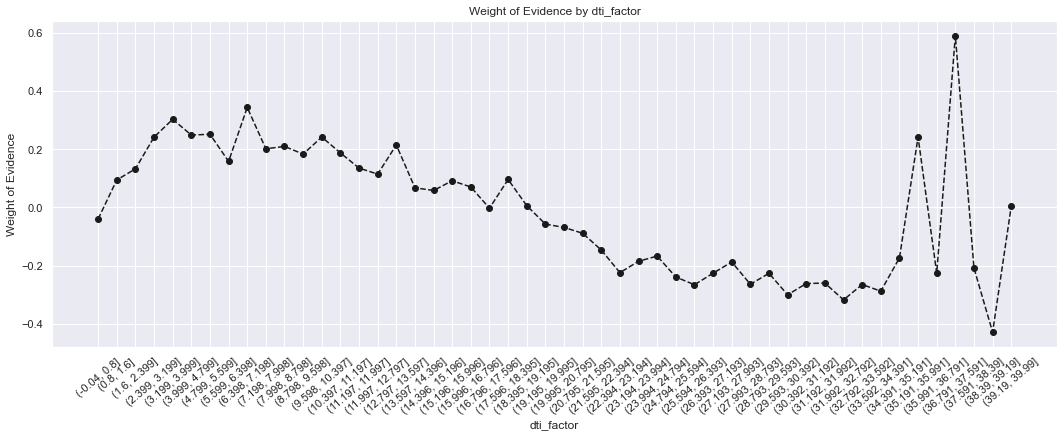

In [474]:
plot_woe(df_temp, 40)
# observation distribution is similar to a bell shape curve. Most observations is below 35

In [475]:
sample_input_df_normDti = sample_input_df.loc[sample_input_df['dti'] <= 35, :] 
sample_input_df_normDti['dti_factor'] = pd.cut(sample_input_df_normDti['dti'], 50)
df_temp = woe_continuous(sample_input_df_normDti, 'dti_factor', sample_target_df[sample_input_df_normDti.index])
df_temp

<ipython-input-475-ebd457e42f40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_normDti['dti_factor'] = pd.cut(sample_input_df_normDti['dti'], 50)


,dti_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.035, 0.7]",328,0.884146,0.003544,290.0,38.0,0.003518,0.003758,-0.066005,NaN,NaN,0.033919
1,"(0.7, 1.4]",393,0.903308,0.004246,355.0,38.0,0.004306,0.003758,0.136232,0.019162,0.202237,0.033919
2,"(1.4, 2.1]",536,0.895522,0.005792,480.0,56.0,0.005823,0.005538,0.050135,0.007785,0.086097,0.033919
3,"(2.1, 2.8]",607,0.915980,0.006559,556.0,51.0,0.006745,0.005044,0.290643,0.020458,0.240508,0.033919
4,"(2.8, 3.5]",811,0.924784,0.008763,750.0,61.0,0.009098,0.006032,0.410900,0.008804,0.120257,0.033919
5,"(3.5, 4.2]",970,0.903093,0.010481,876.0,94.0,0.010626,0.009296,0.133772,0.021691,0.277128,0.033919
6,"(4.2, 4.9]",1140,0.913158,0.012318,1041.0,99.0,0.012628,0.009790,0.254518,0.010065,0.120746,0.033919
7,"(4.9, 5.6]",1370,0.911679,0.014803,1249.0,121.0,0.015151,0.011966,0.236009,0.001479,0.018509,0.033919
8,"(5.6, 6.3]",1491,0.904762,0.016111,1349.0,142.0,0.016364,0.014043,0.152992,0.006917,0.083016,0.033919
9,"(6.3, 7.0]",1722,0.926829,0.018607,1596.0,126.0,0.019360,0.012460,0.440674,0.022067,0.287682,0.033919


In [476]:
sample_input_df['dti:<=1.4'] = np.where((sample_input_df['dti'] <= 1.4), 1, 0)
sample_input_df['dti:1.4-3.5'] = np.where((sample_input_df['dti'] > 1.4) & (sample_input_df['dti'] <= 3.5), 1, 0)
sample_input_df['dti:3.5-7.7'] = np.where((sample_input_df['dti'] > 3.5) & (sample_input_df['dti'] <= 7.7), 1, 0)
sample_input_df['dti:7.7-10.5'] = np.where((sample_input_df['dti'] > 7.7) & (sample_input_df['dti'] <= 10.5), 1, 0)
sample_input_df['dti:10.5-16.1'] = np.where((sample_input_df['dti'] > 10.5) & (sample_input_df['dti'] <= 16.1), 1, 0)
sample_input_df['dti:16.1-20.3'] = np.where((sample_input_df['dti'] > 16.1) & (sample_input_df['dti'] <= 20.3), 1, 0)
sample_input_df['dti:20.3-21.7'] = np.where((sample_input_df['dti'] > 20.3) & (sample_input_df['dti'] <= 21.7), 1, 0)
sample_input_df['dti:21.7-22.4'] = np.where((sample_input_df['dti'] > 21.7) & (sample_input_df['dti'] <= 22.4), 1, 0)
sample_input_df['dti:22.4-35'] = np.where((sample_input_df['dti'] > 22.4) & (sample_input_df['dti'] <= 35), 1, 0)
sample_input_df['dti:>35'] = np.where((sample_input_df['dti'] > 35), 1, 0)

In [477]:
#mths_since_last_record
sample_input_df_lastRecord = sample_input_df[pd.notnull(sample_input_df['mths_since_last_record'])]
sample_input_df_lastRecord['mths_since_last_record_factor'] = pd.cut(sample_input_df_lastRecord['mths_since_last_record'],50)
df_temp = woe_continuous(sample_input_df_lastRecord, 'mths_since_last_record_factor', sample_target_df[sample_input_df_lastRecord.index])
df_temp

<ipython-input-477-3063b5d76e77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_lastRecord['mths_since_last_record_factor'] = pd.cut(sample_input_df_lastRecord['mths_since_last_record'],50)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_record_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.129, 2.58]",244,0.741803,0.019410,181.0,63.0,0.016036,0.049065,-1.118309,NaN,NaN,inf
1,"(2.58, 5.16]",36,0.888889,0.002864,32.0,4.0,0.002835,0.003115,-0.094230,0.147086,1.024079,inf
2,"(5.16, 7.74]",39,0.923077,0.003102,36.0,3.0,0.003190,0.002336,0.311235,0.034188,0.405465,inf
3,"(7.74, 10.32]",66,0.939394,0.005250,62.0,4.0,0.005493,0.003115,0.567169,0.016317,0.255933,inf
4,"(10.32, 12.9]",42,0.833333,0.003341,35.0,7.0,0.003101,0.005452,-0.564234,0.106061,1.131402,inf
5,"(12.9, 15.48]",69,0.869565,0.005489,60.0,9.0,0.005316,0.007009,-0.276551,0.036232,0.287682,inf
6,"(15.48, 18.06]",95,0.863158,0.007557,82.0,13.0,0.007265,0.010125,-0.331902,0.006407,0.055350,inf
7,"(18.06, 20.64]",58,0.965517,0.004614,56.0,2.0,0.004961,0.001558,1.158533,0.102359,1.490435,inf
8,"(20.64, 23.22]",101,0.891089,0.008034,90.0,11.0,0.007974,0.008567,-0.071757,0.074428,1.230290,inf
9,"(23.22, 25.8]",94,0.946809,0.007478,89.0,5.0,0.007885,0.003894,0.705527,0.055719,0.777284,inf


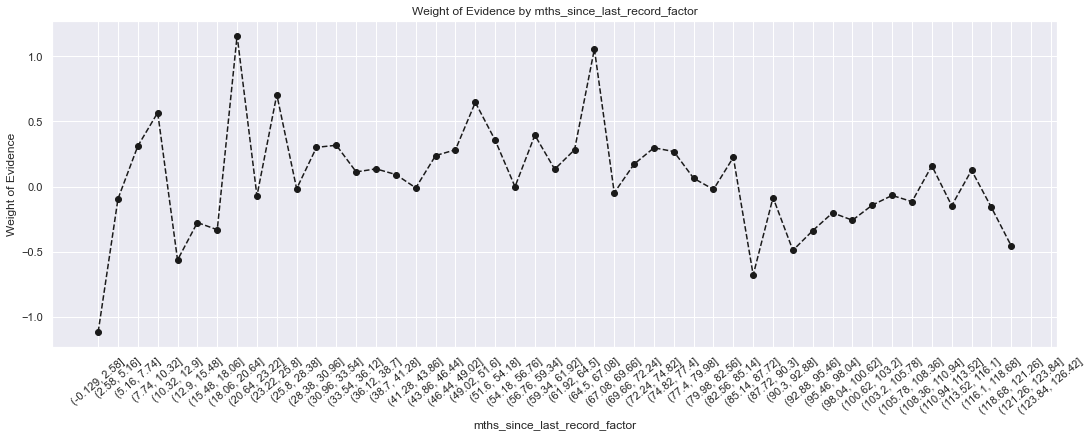

In [478]:
plot_woe(df_temp, 40)

In [479]:
sample_input_df['mths_since_last_record:Missing'] = np.where((sample_input_df['mths_since_last_record'].isnull()), 1, 0)
sample_input_df['mths_since_last_record:0-2'] = np.where((sample_input_df['mths_since_last_record'] >= 0) & (sample_input_df['mths_since_last_record'] <= 2), 1, 0)
sample_input_df['mths_since_last_record:3-20'] = np.where((sample_input_df['mths_since_last_record'] >= 3) & (sample_input_df['mths_since_last_record'] <= 20), 1, 0)
sample_input_df['mths_since_last_record:21-31'] = np.where((sample_input_df['mths_since_last_record'] >= 21) & (sample_input_df['mths_since_last_record'] <= 31), 1, 0)
sample_input_df['mths_since_last_record:32-80'] = np.where((sample_input_df['mths_since_last_record'] >= 32) & (sample_input_df['mths_since_last_record'] <= 80), 1, 0)
sample_input_df['mths_since_last_record:81-86'] = np.where((sample_input_df['mths_since_last_record'] >= 81) & (sample_input_df['mths_since_last_record'] <= 86), 1, 0)
sample_input_df['mths_since_last_record:>86'] = np.where((sample_input_df['mths_since_last_record'] > 86), 1, 0)

In [480]:
#up until this point, we have used the sample_input_df to create all kinds of dummy variables for the training purpose. Now, copy this df into the training data set as a backup
# inputs_train = sample_input_df
#previously, before doing the data preparation, we have copied training data set into the sample_input_df

In [481]:
#we have to create all of the dummy variables and data preparation steps as above for the testing data set as well. 
# so in the step above, that we copied training data set into the sample_input_df, we uncommented that out --> copy testing data set into sample_input_df instead
# then run everything up to the cell above. 
#NOTE: do no run the step back up sample_input_df into inputs_train either.
# like the previous cell, copy this sample_input_df into the test data set as a backup
inputs_test = sample_input_df

In [482]:
# export the training data sets and the testing data sets into csv. Shall work with these prepocessed csv data
inputs_train.to_csv(os.path.join(path_datamart, 'inputs_train.csv'))
targets_train.to_csv(os.path.join(path_datamart, 'targets_train.csv'))
inputs_test.to_csv(os.path.join(path_datamart, 'inputs_test.csv'))
targets_test.to_csv(os.path.join(path_datamart, 'targets_test.csv'))

### The End